In [1]:
from bertopic import BERTopic
import numpy as np
import pandas as pd
from transformers import pipeline
from bertopic.representation import TextGeneration
from bertopic.vectorizers import ClassTfidfTransformer
from sentence_transformers import SentenceTransformer
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import datetime
import nltk
from nltk.corpus import stopwords
import logging
import os
from dotenv import load_dotenv
from umap import UMAP
import hdbscan
from sklearn.feature_extraction.text import CountVectorizer
import openai
import spacy
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, OpenAI, PartOfSpeech
from sklearn.metrics import silhouette_score
import os
from datetime import datetime
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from deep_translator import GoogleTranslator

# Auxiliary Functions

In [2]:
def auto_save_figure(fig, figure_name, save_formats=['png'], 
                    width=1000, height=700, scale=2, output_dir="../../outputs/plots"):
    """
    Automatically save any Plotly or Matplotlib figure to disk with multiple formats and timestamp
    
    Parameters:
    -----------
    fig : plotly.graph_objects.Figure or matplotlib.figure.Figure
        The figure to save (supports both Plotly and Matplotlib)
    figure_name : str
        Descriptive name for the figure (will be used in filename)
    save_formats : list
        List of formats to save ['png', 'html', 'pdf', 'svg', 'jpeg']
    width : int
        Width of the saved image
    height : int
        Height of the saved image
    scale : int
        Scale factor for image resolution (higher = better quality)
    output_dir : str
        Directory to save the figures
    
    Returns:
    --------
    dict : Dictionary with saved file paths
    """
    if fig is None:
        print(f"❌ No figure provided for '{figure_name}'")
        return {}
    
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Generate timestamp for unique filenames
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    saved_files = {}
    
    # Detect figure type
    is_plotly = hasattr(fig, 'write_image') and hasattr(fig, 'write_html')
    is_matplotlib = hasattr(fig, 'savefig')
    
    if not is_plotly and not is_matplotlib:
        print(f"❌ Unsupported figure type for '{figure_name}': {type(fig)}")
        return {}
    
    for format_type in save_formats:
        # Clean figure name for filename (remove spaces, special chars)
        clean_name = "".join(c for c in figure_name if c.isalnum() or c in (' ', '-', '_')).rstrip()
        clean_name = clean_name.replace(' ', '_').lower()
        
        filename = f"{timestamp}_{clean_name}.{format_type}"
        filepath = os.path.join(output_dir, filename)
        
        try:
            if is_plotly:
                # Handle Plotly figures
                if format_type == 'html':
                    fig.write_html(filepath)
                    print(f"📊 Saved {figure_name} as HTML: {filename}")
                elif format_type in ['png', 'pdf', 'svg', 'jpeg']:
                    fig.write_image(
                        filepath,
                        width=width,
                        height=height,
                        scale=scale,
                        format=format_type
                    )
                    print(f"🖼️  Saved {figure_name} as {format_type.upper()}: {filename}")
                    
            elif is_matplotlib:
                # Handle Matplotlib figures
                if format_type == 'html':
                    # Convert matplotlib to HTML via mpld3 (if available) or skip
                    try:
                        import mpld3
                        html_str = mpld3.fig_to_html(fig)
                        with open(filepath, 'w') as f:
                            f.write(html_str)
                        print(f"📊 Saved {figure_name} as HTML: {filename}")
                    except ImportError:
                        print(f"⚠️  Skipping HTML for matplotlib figure '{figure_name}' (mpld3 not available)")
                        continue
                elif format_type in ['png', 'pdf', 'svg', 'jpeg']:
                    # Set DPI based on scale
                    dpi = 100 * scale
                    fig.savefig(
                        filepath,
                        format=format_type,
                        dpi=dpi,
                        bbox_inches='tight',
                        facecolor='white',
                        edgecolor='none'
                    )
                    print(f"🖼️  Saved {figure_name} as {format_type.upper()}: {filename}")
            
            saved_files[format_type] = os.path.abspath(filepath)
            
        except Exception as e:
            print(f"❌ Error saving {figure_name} as {format_type}: {e}")
    
    if saved_files:
        print(f"✅ Total saved: {len(saved_files)} file(s) for '{figure_name}'")
        print(f"📁 Location: {os.path.abspath(output_dir)}")
        print("-" * 60)
    
    return saved_files

In [3]:
def enhance_bertopic_figure(fig, viz_type):
    """
    Enhance BERTopic figures with specific optimizations for each visualization type
    
    Parameters:
    -----------
    fig : plotly.graph_objects.Figure
        The BERTopic figure to enhance
    viz_type : str
        Type of visualization ('topics', 'topics_per_class', 'heatmap', etc.)
    
    Returns:
    --------
    plotly.graph_objects.Figure : Enhanced figure
    """
    if fig is None:
        return fig
        
    try:
        if viz_type == 'topics':
            # Fix intertopic distance map cropping issues
            fig.update_layout(
                # Increase margins to prevent cropping
                margin=dict(l=80, r=80, t=100, b=80),
                # Ensure proper aspect ratio
                width=1200,
                height=900,
                # Add padding to prevent cluster cutoff
                xaxis=dict(
                    range=None,  # Let plotly auto-scale
                    automargin=True,
                    showgrid=True,
                    gridcolor='rgba(0,0,0,0.1)'
                ),
                yaxis=dict(
                    range=None,  # Let plotly auto-scale  
                    automargin=True,
                    showgrid=True,
                    gridcolor='rgba(0,0,0,0.1)'
                ),
                # Improve title positioning
                title=dict(
                    x=0.5,
                    xanchor='center',
                    y=0.95,
                    font=dict(size=16)
                )
            )
            
        elif viz_type == 'topics_per_class':
            # Ensure all topics are visible (not just the first one)
            # Make all traces visible by default
            if hasattr(fig, 'data'):
                for trace in fig.data:
                    trace.visible = True
                    
            # Improve layout for topics per class
            fig.update_layout(
                margin=dict(l=60, r=60, t=120, b=60),
                width=1200,
                height=800,
                # Ensure legend is visible and functional
                showlegend=True,
                legend=dict(
                    orientation="v",
                    yanchor="top",
                    y=1,
                    xanchor="left",
                    x=1.02,
                    bgcolor='rgba(255,255,255,0.8)',
                    bordercolor='rgba(0,0,0,0.3)',
                    borderwidth=1
                ),
                # Improve title
                title=dict(
                    x=0.5,
                    xanchor='center',
                    font=dict(size=16)
                )
            )
            
        elif viz_type == 'heatmap':
            # Optimize heatmap layout
            fig.update_layout(
                margin=dict(l=120, r=80, t=100, b=120),
                width=1000,
                height=700
            )
            
        elif viz_type == 'document_datamap':
            # Optimize document datamap
            fig.update_layout(
                margin=dict(l=80, r=80, t=100, b=80),
                width=1200,
                height=900
            )
            
        elif viz_type == 'hierarchy':
            # Optimize hierarchy plot
            fig.update_layout(
                margin=dict(l=100, r=100, t=100, b=100),
                width=1400,
                height=800
            )
            
    except Exception as e:
        print(f"⚠️  Warning: Could not enhance {viz_type} figure: {e}")
        
    return fig

In [4]:
def get_figure_dimensions(fig):
    """
    Safely extract width and height from a Plotly figure
    """
    try:
        # Try to access width and height from layout
        layout = fig.layout if hasattr(fig, 'layout') else None
        if layout:
            width = getattr(layout, 'width', None) or 1000
            height = getattr(layout, 'height', None) or 700
            return width, height
    except:
        pass
    
    # Fallback to defaults
    return 1000, 700

In [5]:
# Enhanced wrapper function for BERTopic visualizations with optimizations
def save_bertopic_figure_enhanced(fig, viz_type, group_name="Female_ADHD", apply_enhancements=True, **kwargs):
    """
    Enhanced function for saving BERTopic visualizations with automatic optimizations
    
    Parameters:
    -----------
    fig : plotly.graph_objects.Figure or matplotlib.figure.Figure
        The BERTopic figure to save
    viz_type : str
        Type of visualization ('topics', 'heatmap', 'hierarchy', 'topics_per_class', etc.)
    group_name : str
        Name of the group being analyzed
    apply_enhancements : bool
        Whether to apply BERTopic-specific enhancements (default: True)
    **kwargs : additional arguments passed to auto_save_figure
    """
    # Apply enhancements if requested and if it's a Plotly figure
    if apply_enhancements and hasattr(fig, 'update_layout'):
        print(f"🔧 Applying {viz_type} specific optimizations...")
        fig = enhance_bertopic_figure(fig, viz_type)
    
    figure_name = f"bertopic_{viz_type}_{group_name}"
    
    # Set default high-quality settings for BERTopic figures
    kwargs.setdefault('save_formats', ['png', 'html'])
    kwargs.setdefault('scale', 2)
    
    # Safely get figure dimensions
    width, height = get_figure_dimensions(fig)
    kwargs.setdefault('width', width)
    kwargs.setdefault('height', height)
    
    return auto_save_figure(fig, figure_name, **kwargs)

In [6]:
def translate_topic_words(topic_model, target_language='en', source_language='pt'):
    """
    Translate topic words from Portuguese to English
    """
    translator = GoogleTranslator(source=source_language, target=target_language)
    
    # Hardcoded translations for specific terms
    hardcoded_translations = {
        'phda': 'adhd',
        'PHDA': 'ADHD',
        'Phda': 'ADHD'
    }
    
    topics_dict = topic_model.get_topics()
    translated_topics = {}
    
    for topic_id, words_scores in topics_dict.items():
        if topic_id == -1:  # Skip noise topic
            continue
            
        # Extract just the words (first element of each tuple)
        words = [word for word, score in words_scores]
        
        # Translate words
        try:
            translated_words = []
            for word in words:
                # Check if we have a hardcoded translation first
                if word in hardcoded_translations:
                    translated = hardcoded_translations[word]
                else:
                    translated = translator.translate(word)
                translated_words.append(translated)
            
            # Keep the same scores but with translated words
            translated_topic = [(translated_words[i], score) for i, (word, score) in enumerate(words_scores)]
            translated_topics[topic_id] = translated_topic
            
        except Exception as e:
            print(f"Error translating topic {topic_id}: {e}")
            # Keep original if translation fails
            translated_topics[topic_id] = words_scores
    
    return translated_topics

In [7]:
def visualize_barchart_translated_fixed(topic_model, translated_topics, topics=None, top_k_topics=6, n_words=5, 
                                        custom_labels=True, title="<b>Topic Word Scores</b>", 
                                        width=800, height=600):
    """
    Create a bar chart visualization in the exact same style as BERTopic's visualize_barchart
    but with translated words - FIXED VERSION for proper label mapping
    """
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    
    # Get topic information and prepare data
    topic_info = topic_model.get_topic_info()
    
    # Select topics to show (excluding outliers/noise topic -1)
    if topics is None:
        # Get top k topics by size (excluding noise topic -1)
        selected_topics = topic_info[topic_info['Topic'] != -1].head(top_k_topics)['Topic'].tolist()
    else:
        # Filter out -1 from provided topics
        selected_topics = [t for t in topics if t != -1]
    
    # Filter selected_topics to only include those that exist in translated_topics
    available_topics = [topic_id for topic_id in selected_topics if topic_id in translated_topics]
    
    print(f"DEBUG: Available topics for plotting: {available_topics}")
    
    # Create subplot titles ONLY for the topics that will actually be plotted
    # The key fix: properly map topic IDs to their position in the topic_info dataframe
    subplot_titles = []
    for topic_id in available_topics:
        if custom_labels and hasattr(topic_model, 'custom_labels_') and topic_model.custom_labels_:
            # Find the topic in topic_info and get its custom label
            topic_row = topic_info[topic_info['Topic'] == topic_id]
            if not topic_row.empty and 'CustomName' in topic_row.columns:
                topic_label = topic_row.iloc[0]['CustomName']
            elif not topic_row.empty and 'Name' in topic_row.columns:
                topic_label = topic_row.iloc[0]['Name']
            else:
                # Fallback: try to get from custom_labels_ array using topic position
                # Find the position of this topic in the topic_info (excluding outliers)
                non_outlier_topics = topic_info[topic_info['Topic'] != -1]
                topic_position = None
                for idx, row in non_outlier_topics.iterrows():
                    if row['Topic'] == topic_id:
                        topic_position = list(non_outlier_topics.index).index(idx)
                        break
                
                if topic_position is not None and topic_position < len(topic_model.custom_labels_):
                    topic_label = topic_model.custom_labels_[topic_position]
                else:
                    topic_label = f"Topic {topic_id}"
        else:
            topic_label = f"Topic {topic_id}"
        
        print(f"DEBUG: Topic {topic_id} -> Label: {topic_label}")
        subplot_titles.append(topic_label)
    
    # Prepare subplot structure - one row per topic that will actually be plotted
    n_topics = len(available_topics)
    if n_topics == 0:
        print("No topics available for plotting")
        return None
        
    fig = make_subplots(
        rows=n_topics, 
        cols=1,
        shared_xaxes=False,
        vertical_spacing=0.08,
        subplot_titles=subplot_titles
    )
    
    # Color scheme similar to BERTopic
    colors = ["#D55E00", "#0072B2", "#CC79A7", "#E69F00", "#56B4E9", "#009E73", "#F0E442"]
    
    # Process each topic that will actually be plotted
    for i, topic_id in enumerate(available_topics):
        # Get translated words and scores
        words_scores = translated_topics[topic_id][:n_words]
        words = [word for word, score in words_scores]
        scores = [score for word, score in words_scores]
        
        # Reverse order for proper display (highest scores at top)
        words = words[::-1]
        scores = scores[::-1]
        
        # Create horizontal bar trace
        trace = go.Bar(
            y=words,
            x=scores,
            orientation='h',
            marker=dict(
                color=colors[i % len(colors)],
                line=dict(color='rgba(0,0,0,0.3)', width=0.5)
            ),
            text=[f"{score:.3f}" for score in scores],
            textposition='outside',
            textfont=dict(size=11),
            hovertemplate='<b>%{y}</b><br>Score: %{x:.3f}<extra></extra>',
            showlegend=False,
            name=f"Topic {topic_id}"
        )
        
        fig.add_trace(trace, row=i+1, col=1)
    
    # Update layout to match BERTopic style
    fig.update_layout(
        title=dict(
            text=title,
            x=0.5,
            xanchor="center",
            font=dict(size=16, color="black")
        ),
        height=height,
        width=width,
        plot_bgcolor='white',
        paper_bgcolor='white',
        font=dict(color="black", size=11),
        margin=dict(l=10, r=10, t=60, b=10)
    )
    
    # Update axes for each subplot
    for i in range(n_topics):
        # X-axis
        fig.update_xaxes(
            showgrid=True,
            gridwidth=1,
            gridcolor='rgba(0,0,0,0.1)',
            zeroline=True,
            zerolinewidth=1,
            zerolinecolor='rgba(0,0,0,0.3)',
            showline=True,
            linewidth=1,
            linecolor='black',
            row=i+1, col=1
        )
        
        # Y-axis
        fig.update_yaxes(
            showgrid=False,
            showline=True,
            linewidth=1,
            linecolor='black',
            tickfont=dict(size=10),
            row=i+1, col=1
        )
    
    # Update annotation style for subplot titles
    fig.update_annotations(font_size=12, font_color="black")
    
    return fig

In [8]:
def get_silhouette_score(topic_model, embeddings):
    """
    Calculate silhouette score for topic clustering quality assessment
    
    Parameters:
    -----------
    topic_model : BERTopic
        The trained BERTopic model
    embeddings : np.array
        Original document embeddings used for training
        
    Returns:
    --------
    float : Silhouette score (-1 to 1, higher is better)
    """
    # Get document-topic assignments
    document_topics = topic_model.topics_
    
    # Validate inputs
    if len(embeddings) != len(document_topics):
        print(f"Warning: Embedding length ({len(embeddings)}) != topic assignments length ({len(document_topics)})")
        # Use the minimum length to avoid index errors
        min_len = min(len(embeddings), len(document_topics))
        embeddings = embeddings[:min_len]
        document_topics = document_topics[:min_len]
    
    # Filter out outlier/noise topics (-1)
    valid_indices = [i for i, topic in enumerate(document_topics) if topic != -1]
    
    # Check if we have enough valid documents and topics
    if len(valid_indices) < 2:
        print("Warning: Not enough valid documents (non-outlier) for silhouette score calculation")
        return 0.0
    
    # Get unique topics (excluding -1)
    unique_topics = list(set([topic for topic in document_topics if topic != -1]))
    if len(unique_topics) < 2:
        print("Warning: Need at least 2 topics for silhouette score calculation")
        return 0.0
    
    # Use UMAP embeddings for silhouette calculation (lower dimensional space)
    try:
        # Transform embeddings to UMAP space
        umap_embeddings = topic_model.umap_model.transform(embeddings)
        
        # Filter to valid documents only
        X_valid = umap_embeddings[valid_indices]
        labels_valid = [document_topics[i] for i in valid_indices]
        
        # Calculate silhouette score
        score = silhouette_score(X_valid, labels_valid)
        
        print(f"Silhouette score calculated on {len(X_valid)} documents across {len(unique_topics)} topics")
        return score
        
    except Exception as e:
        print(f"Error calculating silhouette score: {e}")
        print("Falling back to original embeddings...")
        
        # Fallback: use original embeddings if UMAP transform fails
        try:
            X_valid = embeddings[valid_indices]
            labels_valid = [document_topics[i] for i in valid_indices]
            score = silhouette_score(X_valid, labels_valid)
            print(f"Silhouette score calculated on original embeddings: {len(X_valid)} documents")
            return score
        except Exception as e2:
            print(f"Error with fallback calculation: {e2}")
            return 0.0

In [9]:
def calculate_topic_coherence_umass(topic_model, texts, vectorizer_model=None, top_k_words=10):
    """
    UMass topic coherence (Mimno et al.): average over ordered word pairs (j<i) of
        log((D(w_i, w_j) + 1) / D(w_j)),
    where D(.) counts documents containing the term(s). Scores are typically negative;
    higher (closer to 0) is better.
    """
    import numpy as np
    from scipy import sparse

    # Prefer the model's vectorizer to keep vocab/preprocessing aligned
    if vectorizer_model is None and hasattr(topic_model, "vectorizer_model") and topic_model.vectorizer_model is not None:
        print("Vectorizer available!")
        vectorizer_model = topic_model.vectorizer_model

    # Fallback if the model has none
    if vectorizer_model is None:
        from sklearn.feature_extraction.text import CountVectorizer
        vectorizer_model = CountVectorizer(
            ngram_range=(1, 2),
            lowercase=True,
            token_pattern=r"(?u)\b\w\w+\b"
        )

    # Use transform if already fitted to preserve vocab; else fit
    if hasattr(vectorizer_model, "vocabulary_") and vectorizer_model.vocabulary_:
        X = vectorizer_model.transform(texts)
        feature_names = np.array(sorted(vectorizer_model.vocabulary_, key=vectorizer_model.vocabulary_.get))
    else:
        X = vectorizer_model.fit_transform(texts)
        feature_names = vectorizer_model.get_feature_names_out()

    # Boolean presence matrix (sparse)
    X = X.astype(bool).astype(int)  # keeps it sparse CSR

    # Fast doc freq helper on sparse columns
    def df(col_idx):
        return X[:, col_idx].sum()

    # Word -> column index
    word_to_idx = {w: i for i, w in enumerate(feature_names)}

    topics = topic_model.get_topics()
    topic_coherences = {}

    for topic_id, word_scores in topics.items():
        if topic_id == -1:
            continue
        words = [w for (w, _) in word_scores[:top_k_words]]

        pair_scores = []
        for i in range(1, len(words)):
            wi = words[i]
            if wi not in word_to_idx:
                continue
            i_idx = word_to_idx[wi]
            for j in range(i):
                wj = words[j]
                if wj not in word_to_idx:
                    continue
                j_idx = word_to_idx[wj]

                Dj = df(j_idx)
                if Dj == 0:
                    continue  # undefined conditioning; skip

                # co-doc frequency via elementwise multiply (still sparse)
                Dij = X[:, i_idx].multiply(X[:, j_idx]).sum()

                # UMass with +1 smoothing on the numerator
                pair_scores.append(np.log((Dij + 1.0) / Dj))

        topic_coherences[topic_id] = float(np.mean(pair_scores)) if pair_scores else float("nan")

    # Average across non-NaN topics
    valid = [v for v in topic_coherences.values() if np.isfinite(v)]
    avg = float(np.mean(valid)) if valid else float("nan")

    return {
        "topic_coherences": topic_coherences,
        "average_coherence": avg,
        "method": "UMass",
        "top_k_words": top_k_words,
        "description": "UMass coherence using document co-occurrence with +1 smoothing; higher (less negative) is better."
    }


In [10]:
def load_bert_model(path):
    return BERTopic.load(path, embedding_model=SentenceTransformer("PORTULAN/serafim-900m-portuguese-pt-sentence-encoder"))

In [11]:
def get_corresponding_df(df, folder_name):
    if folder_name.startswith("Others_"):
        topic_df = df[df["group"] != "Female_ADHD"]
        print("Others")
    elif folder_name.startswith("Male_ADHD_"):
        topic_df = df[df["group"] == "Male_ADHD"]
        print("Male_ADHD")
    elif folder_name.startswith("Male_noADHD_"):
        topic_df = df[df["group"] == "Male_noADHD"]
        print("Male_noADHD")
    elif folder_name.startswith("Female_"):
        topic_df = df[df["group"].isin(["Female_ADHD", "Female_noADHD"])]
        print("Female")
    elif folder_name.startswith("Male_"):
        topic_df = df[df["group"].isin(["Male_ADHD", "Male_noADHD"])]
        print("Male")
    elif folder_name.startswith("All_"):
        topic_df = df
        print("All")
    return topic_df

# Preload

In [12]:
topic_df = pd.read_pickle("../../data/adhd-beliefs-pt/adhd-beliefs-pt-embeddings-serafim-bertopic.pkl")
topic_df

datetime        sex      adhd_diagnosis  age  \
1    2025-03-30T16:29:47+02:00   Feminino           Não tenho   22   
3    2025-03-31T12:08:00+02:00   Feminino           Não tenho   23   
8    2025-03-31T12:55:43+02:00   Feminino           Não tenho   19   
14   2025-03-31T13:54:40+02:00   Feminino           Não tenho   25   
15   2025-03-31T13:58:15+02:00   Feminino  Suspeito que tenho   25   
..                         ...        ...                 ...  ...   
293  2025-06-07T16:05:17+02:00   Feminino  Sim, diagnosticado   51   
296  2025-06-07T17:23:10+02:00   Feminino  Sim, diagnosticado   36   
307  2025-06-10T16:58:08+02:00   Feminino  Sim, diagnosticado   19   
308  2025-06-10T17:45:28+02:00  Masculino  Sim, diagnosticado   19   
312  2025-06-10T23:09:33+02:00   Feminino  Suspeito que tenho   20   

             education             occupation                dialect  \
1         Licenciatura              Estudante  Português de Portugal   
3             Mestrado  Trabalhador-estudante  Português de Portugal   
8         Licenciatura              Estudante  Português de Portugal   
14            Mestrado            Trabalhador  Português de Portugal   
15        Licenciatura            Trabalhador  Português de Portugal   
..                 ...                    ...                    ...   
293           Mestrado  Trabalhador-estudante  Português de Portugal   
296      Pós-Graduação              Estudante  Português de Portugal   
307  Ensino secundário  Trabalhador-estudante  Português de Portugal   
308  Ensino secundário              Estudante  Português de Portugal   
312  Ensino secundário              Estudante  Português de Portugal   

    forgetting_objects forgetting_responsabilities emotion_management  ...  \
1                    3                           3                  4  ...   
3                    2                           1                  4  ...   
8                    3                           2                  2  ...   
14                   4                           3                  4  ...   
15                   4                           2                  5  ...   
..                 ...                         ...                ...  ...   
293                  4                           2                  5  ...   
296                  5                           3                  3  ...   
307                  4                           2                  4  ...   
308                  2                           3                  4  ...   
312                  4                           2                  4  ...   

    need_fast_talk_interest need_fast_talk_information  \
1                         1                          1   
3                         1                          1   
8                         4                          4   
14                        2                          3   
15                        2                          2   
..                      ...                        ...   
293                       3                          2   
296                       2                          3   
307                       4                          4   
308                       1                          1   
312                       1                          1   

    speaking_before_thinking something_to_add something_to_add_timid  \
1                          3                4                      4   
3                          4                4                      4   
8                          2                4                      3   
14                         3                5                      4   
15                         3                5                      5   
..                       ...              ...                    ...   
293                        4                4                      5   
296                        3                4                      3   
307                        4      

In [13]:
folders = [name for name in os.listdir("../../data/adhd-beliefs-pt/bertopic_models/") if os.path.isdir(os.path.join("../../data/adhd-beliefs-pt/bertopic_models/", name))]
folders

['Male_noADHD_20250818_135710_2',
 'old',
 'Male_ADHD_20250818_135710_2',
 'All_20250818_152521_minsize6',
 'Male_20250818_135710_2',
 'Others_20250818_161900_minsize6',
 'backups',
 'Female_20250818_135710_2']

In [14]:
def preliminary_steps(folder):
    print(f"Running preliminary steps for folder: {folder}")
    df_group = get_corresponding_df(topic_df, folder)
    path = f"../../data/adhd-beliefs-pt/bertopic_models/{folder}/"
    output_folder = f"../../outputs/bertopic_results/{folder}/"
    os.makedirs(output_folder, exist_ok=True)
    topic_model = load_bert_model(path)
    return df_group, topic_model, output_folder

In [15]:
def check_hierarchy(topic_model, df_group, output_folder, group_name):
    texts = df_group["response"].tolist()
    hierarchical_topics = topic_model.hierarchical_topics(texts)
    fig_hierarchy = topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics, custom_labels=True)
    save_bertopic_figure_enhanced(fig_hierarchy, 'hierarchy', group_name=group_name, apply_enhancements=True, output_dir=output_folder)
    display(fig_hierarchy)
    
    fig_topics = topic_model.visualize_topics(custom_labels=True)
    save_bertopic_figure_enhanced(fig_topics, 'topics', group_name=group_name, apply_enhancements=True, output_dir=output_folder)
    display(fig_topics)
    print("=" * 60)
    
    tree = topic_model.get_topic_tree(hierarchical_topics)
    print(tree)
    return topic_model

In [16]:
def run_bertopic_evals(topic_model, df_group, output_folder):
    embeddings = np.vstack(df_group["response_embedding"])
    texts = df_group["response"].tolist()
    
    # SILHOUETTE SCORE
    silhouette_score = get_silhouette_score(topic_model, embeddings)
    print(f"Silhouette Score: {silhouette_score:.4f}")
    with open(f"{output_folder}/silhouette_score.txt", "w") as f:
        f.write(f"{silhouette_score}")
    
    # COHERENCE SCORE - Updated to use UMass
    print("Calculating topic coherence using UMass metric...")
    coherence_results = calculate_topic_coherence_umass(topic_model, texts, top_k_words=10)
    avg_coherence = coherence_results['average_coherence']
    topic_coherences = coherence_results['topic_coherences']
    
    print(f"Average Topic Coherence (UMass): {avg_coherence:.4f}")
    print("Individual Topic Coherences:")
    for topic_id, coherence in topic_coherences.items():
        print(f"  Topic {topic_id}: {coherence:.4f}")
    
    # Save coherence results
    with open(f"{output_folder}/coherence_score.txt", "w") as f:
        f.write(f"Average Coherence (UMass): {avg_coherence}\n")
        f.write("Individual Topic Coherences:\n")
        for topic_id, coherence in topic_coherences.items():
            f.write(f"Topic {topic_id}: {coherence}\n")
    
    # Save detailed coherence results as JSON for further analysis
    import json
    with open(f"{output_folder}/coherence_detailed.json", "w") as f:
        json.dump(coherence_results, f, indent=2)
    
    print(f"Coherence results saved to {output_folder}")
    print("=" * 60)

In [17]:
def run_bertopic_viz(topic_model, df_group, output_folder, group_name):
    texts = df_group["response"].tolist()
    print(f"Number of texts: {len(texts)}")
    print(f"Number of topics: {len(topic_model.topics_)}")
    if len(texts) != len(topic_model.topics_):
        print("Length mismatch detected. The model topics were from different training data.")
        print("Using topic info instead of document info.")
        # We can still use get_topic_info() which works fine
        display(topic_model.get_topic_info())
    else:
        document_info = topic_model.get_document_info(texts)
        document_info.to_csv(f"{output_folder}/document_info.csv", index=False)
        display(document_info)
    print("=" * 60)
        
    fig_heatmap = topic_model.visualize_heatmap(custom_labels=True)
    save_bertopic_figure_enhanced(fig_heatmap, 'heatmap', group_name=group_name, apply_enhancements=True, output_dir=output_folder)
    display(fig_heatmap)
    print("=" * 60)
    
    classes = df_group["question"].tolist()
    topics_per_class = topic_model.topics_per_class(texts, classes=classes)
    fig_topics_per_class = topic_model.visualize_topics_per_class(topics_per_class, custom_labels=True)
    save_bertopic_figure_enhanced(fig_topics_per_class, 'topics_per_class', group_name=group_name, apply_enhancements=True, output_dir=output_folder)
    display(fig_topics_per_class)
    print("=" * 60)

    embeddings = np.vstack(df_group["response_embedding"])
    fig_document_datamap = topic_model.visualize_document_datamap(texts, embeddings=embeddings, custom_labels=True)
    save_bertopic_figure_enhanced(fig_document_datamap, 'document_datamap', group_name=group_name, apply_enhancements=True, output_dir=output_folder)
    display(fig_document_datamap)
    print("=" * 60)

    # Get translated topics
    print("Translating topic words to English...")
    translated_topics = translate_topic_words(topic_model)

    # Display translated topics
    print("\nTranslated Topics (Portuguese → English):")
    print("="*60)
    for topic_id, words_scores in translated_topics.items():
        words = [word for word, score in words_scores[:5]]  # Top 5 words
        print(f"Topic {topic_id}: {', '.join(words)}")
    print("="*60)

    fig_bertopic_style_fixed = visualize_barchart_translated_fixed(
        topic_model, 
        translated_topics, 
        top_k_topics=6, 
        n_words=5,
        custom_labels=True,
        width=1000,
        height=700
    )
        
    if fig_bertopic_style_fixed:
        # Auto-save the translated barchart with enhanced settings
        save_bertopic_figure_enhanced(fig_bertopic_style_fixed, 'translated_barchart', group_name=group_name, apply_enhancements=True, output_dir=output_folder)
        fig_bertopic_style_fixed.show()
    else:
        print("No valid topics to display")
    

# Other Participants

In [18]:
folder = next(f for f in folders if f.startswith("Others_"))
print(folder)
df_group, topic_model, output_folder = preliminary_steps(folder)
check_hierarchy(topic_model, df_group, output_folder, "Others")

Others_20250818_161900_minsize6
Running preliminary steps for folder: Others_20250818_161900_minsize6
Others


100%|██████████| 17/17 [00:00<00:00, 527.04it/s]


🔧 Applying hierarchy specific optimizations...
🖼️  Saved bertopic_hierarchy_Others as PNG: 20250826_234602_bertopic_hierarchy_others.png
📊 Saved bertopic_hierarchy_Others as HTML: 20250826_234602_bertopic_hierarchy_others.html
✅ Total saved: 2 file(s) for 'bertopic_hierarchy_Others'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_results/Others_20250818_161900_minsize6
------------------------------------------------------------


🔧 Applying topics specific optimizations...
🖼️  Saved bertopic_topics_Others as PNG: 20250826_234611_bertopic_topics_others.png
📊 Saved bertopic_topics_Others as HTML: 20250826_234611_bertopic_topics_others.html
✅ Total saved: 2 file(s) for 'bertopic_topics_Others'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_results/Others_20250818_161900_minsize6
------------------------------------------------------------


.
├─dia_hoje_porque_fazer_trabalho
│    ├─memória_anos_lembro_mim_sempre
│    │    ├─■──algum_eventos_dia_perceber_situações ── Topic: 10
│    │    └─memória_anos_lembro_mim_sempre
│    │         ├─■──capaz_exame_nunca_mim_memória ── Topic: 17
│    │         └─memória_anos_lembro_altura_comigo
│    │              ├─■──altura_anos_dizer_comigo_memória ── Topic: 1
│    │              └─■──memória_lembro_avós_anos_morte ── Topic: 3
│    └─dia_hoje_fazer_trabalho_casa
│         ├─dia_hoje_fazer_casa_trabalho
│         │    ├─■──dia_bom_trabalho_campo_super ── Topic: 5
│         │    └─dia_casa_tarde_hoje_manhã
│         │         ├─■──fazer_porque_dia_tempo_coisas ── Topic: 2
│         │         └─■──tarde_pai_casa_hoje_acordei ── Topic: 0
│         └─■──hoje_mãe_pouco_diário_ainda ── Topic: 16
└─gosto_música_forma_vida_adoro
     ├─gosto_música_forma_vida_adoro
     │    ├─pessoas_medo_phda_medicação_vida
     │    │    ├─medo_medicação_phda_pessoas_vida
     │    │    │    ├─■──phda_medi

In [19]:
topic_info = topic_model.get_topic_info()
display(topic_info)
topic_info.to_csv(f"{output_folder}/topic_info.csv", index=False)

Topic  Count                                     Name  \
0      -1     82             -1_escrever_algo_vezes_fazer   
1       0     35                    0_tarde_pai_casa_hoje   
2       1     32               1_altura_anos_dizer_comigo   
3       2     24                 2_fazer_porque_dia_tempo   
4       3     20               3_memória_lembro_avós_anos   
5       4     19                 4_ler_forma_livros_gosto   
6       5     18                 5_dia_bom_trabalho_campo   
7       6     18                6_sentir_dá_adoro_permite   
8       7     18  7_desporto_personagens_história_animais   
9       8     17      8_música_ouvir_músicas_ouvir música   
10      9     15                 9_jogos_jogar_jogo_gosto   
11     10     14            10_algum_eventos_dia_perceber   
12     11     14    11_interessante_física_política_corpo   
13     12     12                12_pessoas_medo_onde_vida   
14     13     11          13_gosto_cozinhar_adoro_pessoas   
15     14     11      14_responder_nenhuma_prefiro_ocorre   
16     15      8     15_phda_medicação_psiquiatra_começar   
17     16      7                 16_hoje_mãe_pouco_diário   
18     17      7                 17_capaz_exame_nunca_mim   

                                       CustomName  \
0                                   Outlier Topic   
1             Daily Life and Family Relationships   
2               Personal Growth and Relationships   
3           Daily Stress and Emotional Challenges   
4                     Childhood Memories and Loss   
5             Reading Fiction and Personal Growth   
6                 Personal Growth and Achievement   
7           Relaxation Through Hobbies and Nature   
8                   Personal Interests in Hobbies   
9                Personal Relationship with Music   
10               Video Games and Game Development   
11        Personal Reflections and Daily Emotions   
12  Interdisciplinary Curiosity and Understanding   
13       Personal Uncertainty and Social Concerns   
14         Personal Tastes and Joyful Experiences   
15              Reluctance or Inability to Answer   
16      ADHD Diagnosis and Medication Experiences   
17       Personal Reflections and Health Concerns   
18             Academic Self-Doubt and Overcoming   

                                       Representation  \
0   [escrever, algo, vezes, fazer, tempo, menos, d...   
1   [tarde, pai, casa, hoje, acordei, ir, dia, man...   
2   [altura, anos, dizer, comigo, memória, hoje, f...   
3   [fazer, porque, dia, tempo, coisas, trabalho, ...   
4   [memória, lembro, avós, anos, morte, sempre, a...   
5   [ler, forma, livros, gosto, histórias, saga, i...   
6   [dia, bom, trabalho, campo, super, ja, feliz, ...   
7   [sentir, dá, adoro, permite, gosto, dia dia, a...   
8   [desporto, personagens, história, animais, ver...   
9   [música, ouvir, músicas, ouvir música, homem, ...   
10  [jogos, jogar, jogo, gosto, sempre, desde pequ...   
11  [algum, eventos, dia, perceber, situações, aco...   
12  [interessante, física, política, corpo, valore...   
13  [pessoas, medo, onde, vida, momento, atenção, ...   
14  [gosto, cozinhar, adoro, pessoas, visitar, fav...   
15  [responder, nenhuma, prefiro, ocorre, pergunta...   
16  [phda, medicação, psiquiatra, começar, estado,...   
17  [hoje, mãe, pouco, diário, ainda, apesar, amiz...   
18  [capaz, exame, nunca, mim, memória, faculdade,...   

                                              KeyBERT  \
0   [fiquei, senti, sinto confortável, muitas veze...   
1   [hoje acordei, acordei, dormi, comecei, hoje, ...   
2   [ansiedade, medo, mim, ia, comigo, momentos, s...   
3   [stress, acordei, stressada, trabalhei, cansaç...   
4   [memória vem, saudades, memória, conheci, emoç...   
5   [livros, livro, ler, relaxar, lido, histórias,...   
6   [fazer, mim, fazemos, tarefas, envolve, fiz, m...   
7   [permite relaxar, gosto fazer, adoro fazer, ap...   
8   [gosto jogar, envolve, desafiantes, especial, ...   
9   [ouvir 

In [20]:
run_bertopic_evals(topic_model, df_group, output_folder)

Silhouette score calculated on 300 documents across 18 topics
Silhouette Score: 0.0400
Calculating topic coherence using UMass metric...
Vectorizer available!
Average Topic Coherence (UMass): -1.5694
Individual Topic Coherences:
  Topic 0: -1.2733
  Topic 1: -1.3271
  Topic 2: -1.6941
  Topic 3: -1.8074
  Topic 4: -1.5899
  Topic 5: -1.9938
  Topic 6: -1.5979
  Topic 7: -1.3006
  Topic 8: -1.0977
  Topic 9: -1.7031
  Topic 10: -1.8471
  Topic 11: -1.2390
  Topic 12: -1.9788
  Topic 13: -1.9576
  Topic 14: -1.2989
  Topic 15: -1.1958
  Topic 16: -1.7846
  Topic 17: -1.5630
Coherence results saved to ../../outputs/bertopic_results/Others_20250818_161900_minsize6/


Number of texts: 382
Number of topics: 382


Document  Topic  \
0    Adoro cozinhar, porque sinto que é a forma ide...     13   
1    Gosto de ver séries porque relatam relações sa...      4   
2    Campos de ferias. Temos que criar o campo todo...      5   
3    Taylor Swift, amo o seu liricismo e a maneira ...      7   
4    Historia da arte \nÉ só tão interessante. Para...     11   
..                                                 ...    ...   
377                                                  —     -1   
378  As vezes aborrece-me ter de escrever/responder...     -1   
379  Maiores dificuldades que sempre senti.. Concen...     12   
380  De momento, na minha cabeça, só rumino sobre o...     17   
381  Alguém me mande um milagre, I am going crazy, ...      0   

                                        Name  \
0            13_gosto_cozinhar_adoro_pessoas   
1                   4_ler_forma_livros_gosto   
2                   5_dia_bom_trabalho_campo   
3    7_desporto_personagens_história_animais   
4      11_interessante_física_política_corpo   
..                                       ...   
377             -1_escrever_algo_vezes_fazer   
378             -1_escrever_algo_vezes_fazer   
379                12_pessoas_medo_onde_vida   
380                 17_capaz_exame_nunca_mim   
381                    0_tarde_pai_casa_hoje   

                                        CustomName  \
0           Personal Tastes and Joyful Experiences   
1              Reading Fiction and Personal Growth   
2                  Personal Growth and Achievement   
3                    Personal Interests in Hobbies   
4    Interdisciplinary Curiosity and Understanding   
..                                             ...   
377                                  Outlier Topic   
378                                  Outlier Topic   
379       Personal Uncertainty and Social Concerns   
380             Academic Self-Doubt and Overcoming   
381            Daily Life and Family Relationships   

                                        Representation  \
0    [gosto, cozinhar, adoro, pessoas, visitar, fav...   
1    [ler, forma, livros, gosto, histórias, saga, i...   
2    [dia, bom, trabalho, campo, super, ja, feliz, ...   
3    [desporto, personagens, história, animais, ver...   
4    [interessante, física, política, corpo, valore...   
..                                                 ...   
377  [escrever, algo, vezes, fazer, tempo, menos, d...   
378  [escrever, algo, vezes, fazer, tempo, menos, d...   
379  [pessoas, medo, onde, vida, momento, atenção, ...   
380  [capaz, exame, nunca, mim, memória, faculdade,...   
381  [tarde, pai, casa, hoje, acordei, ir, dia, man...   

                                               KeyBERT  \
0    [porque gosto, liberdade criativa, gosto ver, ...   
1    [livros, livro, ler, relaxar, lido, histórias,...   
2    [fazer, mim, fazemos, tarefas, envolve, fiz, m...   
3    [gosto jogar, envolve, desafiantes, especial, ...   
4    [várias técnicas, políticas, assuntos, temas, ...   
..                                                 ...   
377  [fiquei, senti, sinto confortável, muitas veze...   
378  [fiquei, senti, sinto confortável, muitas veze...   
379  [vezes medo, medo, dificuldades, saúde mental,...   
380  [stressar, tentar acabar, aulas, depressão, pe...   
381  [hoje acordei, acordei, dormi, comecei, hoje, ...   

                                               OpenAI  \
0            [Personal Tastes and Joyful Experiences]   
1               [Reading Fiction and Personal Growth]   
2                   [Personal Growth and Achievement]   
3                     [Personal Interests in Hobbies]   
4     [Interdisciplinary Curiosity and Understanding]   
..                                                ...   
377  [Personal Productivity and Emotional Challenges]   
378  [Personal Productivity and Emotional Challenges]   
379        [Personal Uncertainty and Social Concerns]   
380              [Academic Self-Doubt and Overcoming]   
381             [D

🔧 Applying heatmap specific optimizations...
🖼️  Saved bertopic_heatmap_Others as PNG: 20250826_234612_bertopic_heatmap_others.png
📊 Saved bertopic_heatmap_Others as HTML: 20250826_234612_bertopic_heatmap_others.html
✅ Total saved: 2 file(s) for 'bertopic_heatmap_Others'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_results/Others_20250818_161900_minsize6
------------------------------------------------------------


4it [00:00, 94.02it/s]

🔧 Applying topics_per_class specific optimizations...


🖼️  Saved bertopic_topics_per_class_Others as PNG: 20250826_234614_bertopic_topics_per_class_others.png
📊 Saved bertopic_topics_per_class_Others as HTML: 20250826_234614_bertopic_topics_per_class_others.html
✅ Total saved: 2 file(s) for 'bertopic_topics_per_class_Others'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_results/Others_20250818_161900_minsize6
------------------------------------------------------------


🖼️  Saved bertopic_document_datamap_Others as PNG: 20250826_234620_bertopic_document_datamap_others.png
📊 Saved bertopic_document_datamap_Others as HTML: 20250826_234620_bertopic_document_datamap_others.html
✅ Total saved: 2 file(s) for 'bertopic_document_datamap_Others'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_results/Others_20250818_161900_minsize6
------------------------------------------------------------


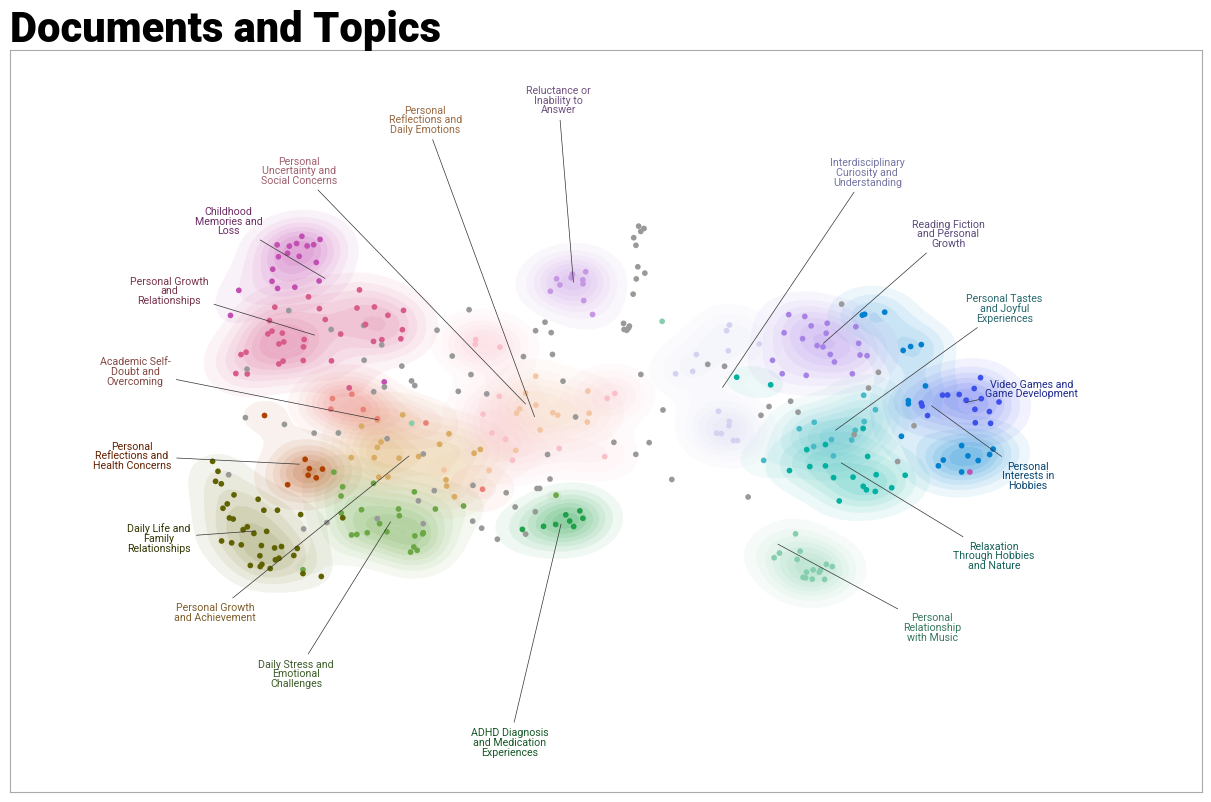

Translating topic words to English...

Translated Topics (Portuguese → English):
Topic 0: afternoon, father, home, today, I woke up
Topic 1: height, years, to say, with me, memory
Topic 2: to do, why, day, time, things
Topic 3: memory, I remember, grandparents, years, death
Topic 4: to read, shape, books, I like, stories
Topic 5: day, good, work, field, super
Topic 6: to feel, from the, I adore, allow, I like
Topic 7: sport, characters, history, animals, see
Topic 8: music, to hear, songs, listen, man
Topic 9: games, to play, game, I like, always
Topic 10: some, events, day, to perceive, situations
Topic 11: interesting, physical, policy, body, values
Topic 12: people, fear, where, life, moment
Topic 13: I like, to cook, I adore, people, visit
Topic 14: to respond, none, I prefer, occur, question
Topic 15: adhd, medication, psychiatrist, to start, state
Topic 16: today, mother, little, daily, yet
Topic 17: able, exam, never, me, memory
DEBUG: Available topics for plotting: [0, 1, 2, 3,

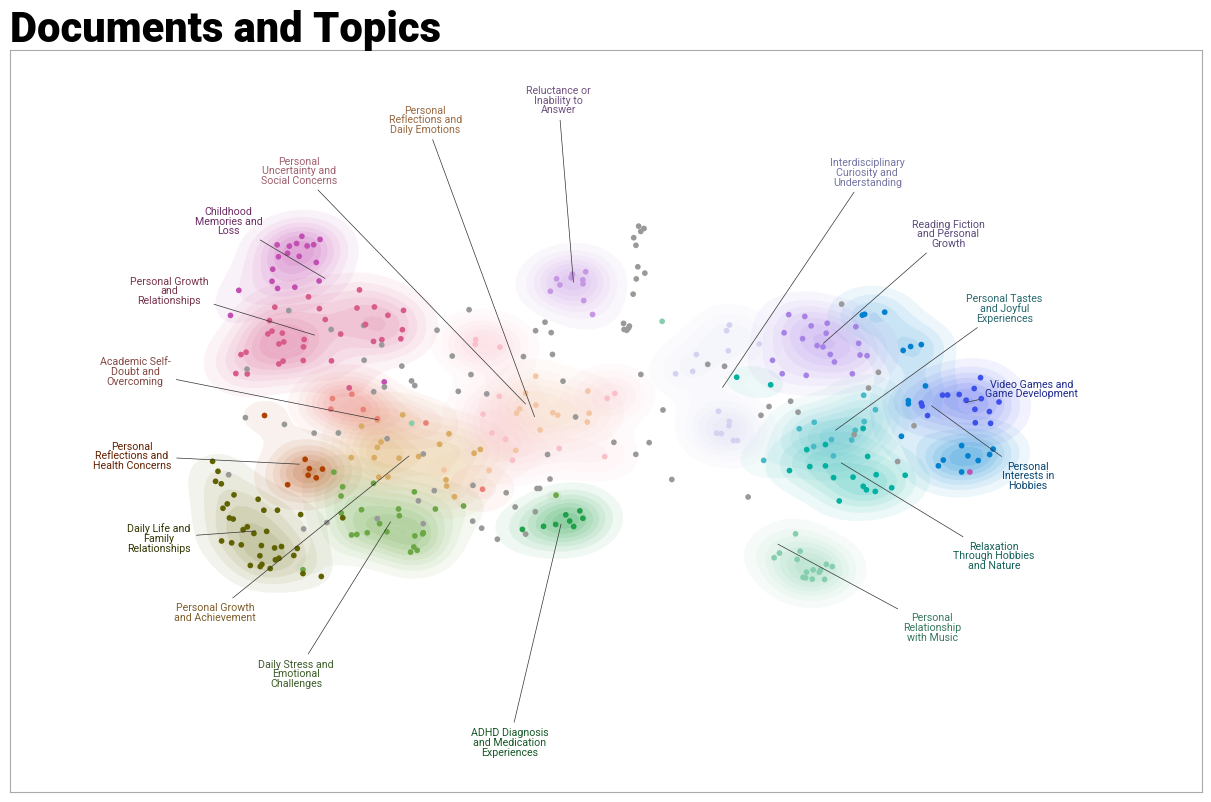

In [21]:
run_bertopic_viz(topic_model, df_group, output_folder, "Others")

# Male ADHD

In [22]:
folder = next(f for f in folders if f.startswith("Male_ADHD_"))
print(folder)
df_group, topic_model, output_folder = preliminary_steps(folder)
check_hierarchy(topic_model, df_group, output_folder, "Male_ADHD")

Male_ADHD_20250818_135710_2
Running preliminary steps for folder: Male_ADHD_20250818_135710_2
Male_ADHD


100%|██████████| 5/5 [00:00<00:00, 488.10it/s]


🔧 Applying hierarchy specific optimizations...
🖼️  Saved bertopic_hierarchy_Male_ADHD as PNG: 20250826_234702_bertopic_hierarchy_male_adhd.png
📊 Saved bertopic_hierarchy_Male_ADHD as HTML: 20250826_234702_bertopic_hierarchy_male_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_hierarchy_Male_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_results/Male_ADHD_20250818_135710_2
------------------------------------------------------------


🔧 Applying topics specific optimizations...
🖼️  Saved bertopic_topics_Male_ADHD as PNG: 20250826_234704_bertopic_topics_male_adhd.png
📊 Saved bertopic_topics_Male_ADHD as HTML: 20250826_234704_bertopic_topics_male_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_Male_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_results/Male_ADHD_20250818_135710_2
------------------------------------------------------------


.
├─gosto_jogo_tudo_algo_vez
│    ├─■──gosto_jogo_algo_sempre_jogar ── Topic: 0
│    └─■──apenas_tudo_todo_coisas_saber ── Topic: 1
└─dia_semana_phda_porque_nada
     ├─semana_phda_pessoas_trabalho_hoje
     │    ├─trabalho_semana_hoje_tarde_porque
     │    │    ├─■──pessoas_empreendedorismo_porque_super_contudo ── Topic: 5
     │    │    └─■──hoje_semana_tarde_casa_nada ── Topic: 3
     │    └─■──phda_medicação_nível_sinto_poder ── Topic: 2
     └─■──mim_dia_saber_nada_ainda ── Topic: 4



In [23]:
topic_info = topic_model.get_topic_info()
display(topic_info)
topic_info.to_csv(f"{output_folder}/topic_info.csv", index=False)

Topic  Count                                     Name  \
0     -1      4             -1_tentar_ainda_qualquer_dia   
1      0      6                 0_gosto_jogo_algo_sempre   
2      1      4                1_apenas_tudo_todo_coisas   
3      2      4             2_phda_medicação_nível_sinto   
4      3      4                 3_hoje_semana_tarde_casa   
5      4      4                     4_mim_dia_saber_nada   
6      5      3  5_pessoas_empreendedorismo_porque_super   

                                          CustomName  \
0                                      Outlier Topic   
1         Enjoyment of Structured Gaming Experiences   
2  Interdisciplinary Curiosity and Human Understa...   
3        ADHD, Depression, and Medication Challenges   
4         Daily Routines and Productivity Challenges   
5           Difficult Personal Memories and Identity   
6                Academic Stress and Personal Growth   

                                      Representation  \
0  [tentar, ainda, qualquer, dia, próximas, começ...   
1  [gosto, jogo, algo, sempre, jogar, fez, vez, v...   
2  [apenas, tudo, todo, coisas, saber, estudo, go...   
3  [phda, medicação, nível, sinto, poder, muitas,...   
4  [hoje, semana, tarde, casa, nada, pois, trabal...   
5  [mim, dia, saber, nada, ainda, sinto, tido, im...   
6  [pessoas, empreendedorismo, porque, super, con...   

                                             KeyBERT  \
0  [fazer, falta, muitas, tempo, embora, tido, ph...   
1  [memórias, buscar, fazer, stressar, partir, jo...   
2  [fazer, várias, saber, coisas, ideias, tipo, v...   
3  [phda, sinto, sair, muitas, medicação, bastant...   
4  [hoje, tempo, dia, ansioso, durante, fazer, ro...   
5  [memórias, sinto, mim, tido, falta, difícil, i...   
6  [stressar, ansioso, mim, vezes, número, rotina...   

                                              OpenAI  \
0             [Human Experience and Daily Struggles]   
1       [Enjoyment of Structured Gaming Experiences]   
2  [Interdisciplinary Curiosity and Human Underst...   
3      [ADHD, Depression, and Medication Challenges]   
4       [Daily Routines and Productivity Challenges]   
5         [Difficult Personal Memories and Identity]   
6              [Academic Stress and Personal Growth]   

                                                 MMR  \
0  [tentar, ainda, próximas, possam, dias, falta,...   
1  [gosto, jogar, vezes, buscar, stressar, qualqu...   
2  [coisas, saber, estudo, várias, perder, ideias...   
3  [phda, medicação, poder, muitas, vida, tomar, ...   
4  [sair, dia, universidade, adhd, 2025, ansioso,...   
5  [ainda, sinto, tido, importante, amigo, memóri...   
6  [empreendedorismo, sempre, vida, correu, coleg...   

                                                 POS  Representative_Docs  
0  [dia, dias, próximas, humana, tempo, falta, ca...                  NaN  
1  [gosto, jogo, vez, vezes, tipo, procura, memór...                  NaN  
2  [coisas, estudo, humana, ideias, cada, pessoa,...                  NaN  
3  [nível, medicação, poder, super, tipo, pessoas...                  NaN  
4  [semana, tarde, casa, trabalho, dia, rotinas, ...                  NaN  
5  [dia, importante, bocado, assunto, difícil, me...                  NaN  
6  [pessoas, empreendedorismo, cabeça, super, vez...                  NaN

In [24]:
run_bertopic_evals(topic_model, df_group, output_folder)

Silhouette score calculated on 25 documents across 6 topics
Silhouette Score: 0.0525
Calculating topic coherence using UMass metric...
Vectorizer available!
Average Topic Coherence (UMass): -0.5774
Individual Topic Coherences:
  Topic 0: -0.5110
  Topic 1: -0.8060
  Topic 2: -0.3526
  Topic 3: -0.4211
  Topic 4: -0.7959
  Topic 5: -0.5775
Coherence results saved to ../../outputs/bertopic_results/Male_ADHD_20250818_135710_2/


Number of texts: 29
Number of topics: 29


Document  Topic  \
0   Não estudo no sentido literal, mas interesso-m...      1   
1                                              Linux!      0   
2   Gosto muito de arrumação gosto de ter tudo arr...      0   
3   Gosto imenso de montanhas russas, às vezes gos...      0   
4   Eu gosto de jogos repetitivos, pois são privis...      0   
5   Um dos meu intereses especiais é ark que é um ...      0   
6   Videografia/cinematografia é uma das áreas da ...      1   
7   Ultimamente, ando particularmente interessado ...      1   
8   Adoro "tudo" no geral, saber como tudo funcion...      1   
9   Literatura dos séculos XIX e XX. Há imensas hi...     -1   
10  Fui diagnosticado recentemente com depressão, ...      2   
11  Portanto são 23:06 já devia de estar a dormir ...      3   
12  Acordei de uma dormida muito curta, e não quer...      3   
13  hoje de manha fui a universidade ter RCR e foi...      3   
14  14 abril 2025\n\nHoje acordei pelas 8h, sabend...      3   
15  Cansado mentalmente  -  10/06/2025\n(Tema/Titu...      5   
16  Provavelmente tentar ler e não conseguir. Tent...     -1   
17  Frequentemente vem-me à cabeça um episódio em ...      4   
18  Eu sinceramente não sei bem responder a este p...      4   
19  Há muitas memórias, uma delas é da primeira re...      0   
20  Genuinamente não sou capaz de me lembrar  de n...      4   
21  O meu gato faleceu quando tinha apenas 7 anos,...     -1   
22  A memória que escolhi é a minha apresentação n...      5   
23  Não vou entrar em detalhes por ser um assunto ...      4   
24  Estou curioso com este estudo, pvf divulguem o...      2   
25  A cabeça está sempre como no redLine do carros...      2   
26  a capacidade da mente humana de desenvolver um...     -1   
27  Ouço muitas pessoas descrever a sua PHDA como ...      2   
28  De momento, na minha cabeça, só rumino sobre o...      5   

                                       Name  \
0                 1_apenas_tudo_todo_coisas   
1                  0_gosto_jogo_algo_sempre   
2                  0_gosto_jogo_algo_sempre   
3                  0_gosto_jogo_algo_sempre   
4                  0_gosto_jogo_algo_sempre   
5                  0_gosto_jogo_algo_sempre   
6                 1_apenas_tudo_todo_coisas   
7                 1_apenas_tudo_todo_coisas   
8                 1_apenas_tudo_todo_coisas   
9              -1_tentar_ainda_qualquer_dia   
10             2_phda_medicação_nível_sinto   
11                 3_hoje_semana_tarde_casa   
12                 3_hoje_semana_tarde_casa   
13                 3_hoje_semana_tarde_casa   
14                 3_hoje_semana_tarde_casa   
15  5_pessoas_empreendedorismo_porque_super   
16             -1_tentar_ainda_qualquer_dia   
17                     4_mim_dia_saber_nada   
18                     4_mim_dia_saber_nada   
19                 0_gosto_jogo_algo_sempre   
20                     4_mim_dia_saber_nada   
21             -1_tentar_ainda_qualquer_dia   
22  5_pessoas_empreendedorismo_porque_super   
23                     4_mim_dia_saber_nada   
24             2_phda_medicação_nível_sinto   
25             2_phda_medicação_nível_sinto   
26             -1_tentar_ainda_qualquer_dia   
27             2_phda_medicação_nível_sinto   
28  5_pessoas_empreendedorismo_porque_super   

                                           CustomName  \
0   Interdisciplinary Curiosity and Human Understa...   
1          Enjoyment of Structured Gaming Experiences   
2          Enjoyment of Structured Gaming Experiences   
3          Enjoyment of Structured Gaming Experiences   
4          Enjoyment of Structured Gaming Experiences   
5          Enjoyment of Structured Gaming Experiences   
6   Interdisciplinary Curiosity and Human Understa...   
7   Interdisciplinary Curiosity and Human Understa...   
8   Interdisciplinary Curiosity and Human Understa...   
9                                       Outlier Topic   
10        ADHD, Depression, and Medication Challenges   
11         Daily Routines and

🔧 Applying heatmap specific optimizations...
🖼️  Saved bertopic_heatmap_Male_ADHD as PNG: 20250826_234705_bertopic_heatmap_male_adhd.png
📊 Saved bertopic_heatmap_Male_ADHD as HTML: 20250826_234705_bertopic_heatmap_male_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_heatmap_Male_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_results/Male_ADHD_20250818_135710_2
------------------------------------------------------------


4it [00:00, 234.36it/s]

🔧 Applying topics_per_class specific optimizations...


🖼️  Saved bertopic_topics_per_class_Male_ADHD as PNG: 20250826_234707_bertopic_topics_per_class_male_adhd.png
📊 Saved bertopic_topics_per_class_Male_ADHD as HTML: 20250826_234707_bertopic_topics_per_class_male_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_per_class_Male_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_results/Male_ADHD_20250818_135710_2
------------------------------------------------------------


🖼️  Saved bertopic_document_datamap_Male_ADHD as PNG: 20250826_234710_bertopic_document_datamap_male_adhd.png
📊 Saved bertopic_document_datamap_Male_ADHD as HTML: 20250826_234710_bertopic_document_datamap_male_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_document_datamap_Male_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_results/Male_ADHD_20250818_135710_2
------------------------------------------------------------


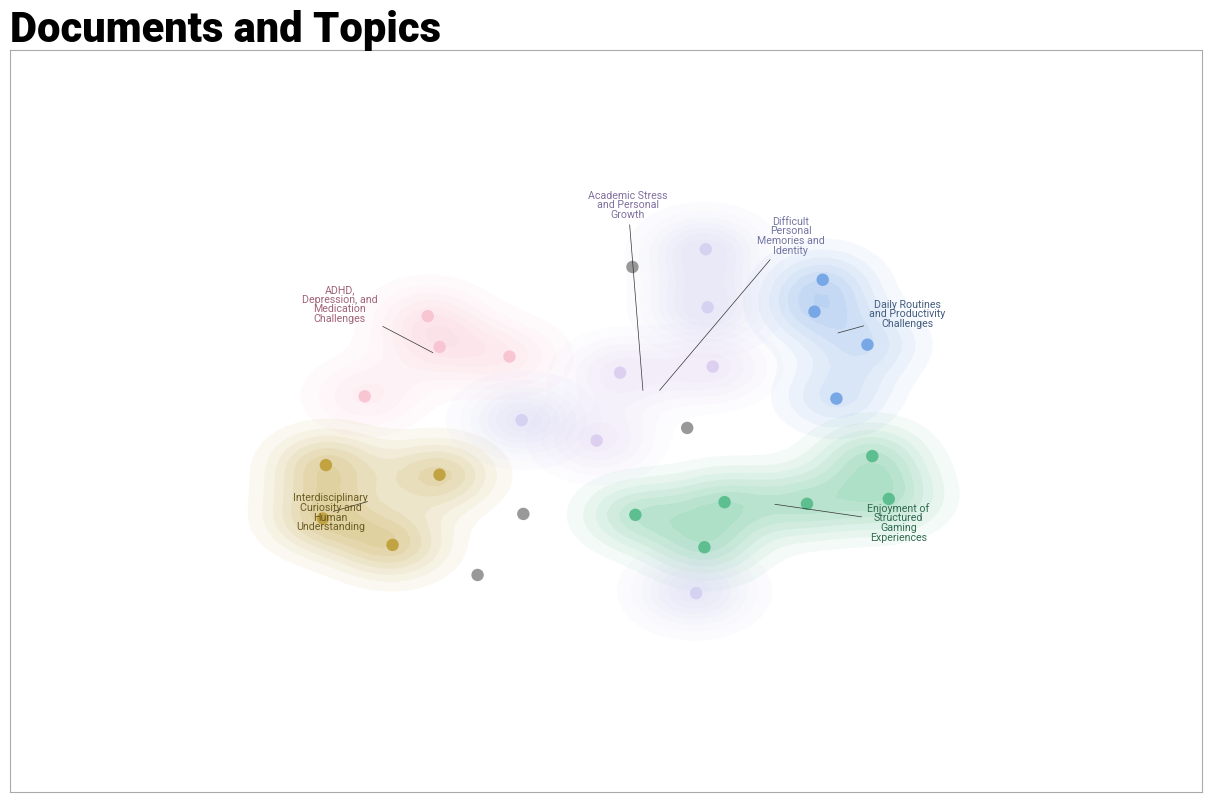

Translating topic words to English...

Translated Topics (Portuguese → English):
Topic 0: I like, game, something, always, to play
Topic 1: just, all, all, things, to know
Topic 2: adhd, medication, level, I feel, power
Topic 3: today, week, afternoon, home, nothing
Topic 4: me, day, to know, nothing, yet
Topic 5: people, entrepreneurship, why, super, however
DEBUG: Available topics for plotting: [0, 1, 2, 3, 4, 5]
DEBUG: Topic 0 -> Label: Enjoyment of Structured Gaming Experiences
DEBUG: Topic 1 -> Label: Interdisciplinary Curiosity and Human Understanding
DEBUG: Topic 2 -> Label: ADHD, Depression, and Medication Challenges
DEBUG: Topic 3 -> Label: Daily Routines and Productivity Challenges
DEBUG: Topic 4 -> Label: Difficult Personal Memories and Identity
DEBUG: Topic 5 -> Label: Academic Stress and Personal Growth
🔧 Applying translated_barchart specific optimizations...
🖼️  Saved bertopic_translated_barchart_Male_ADHD as PNG: 20250826_234723_bertopic_translated_barchart_male_adhd.png

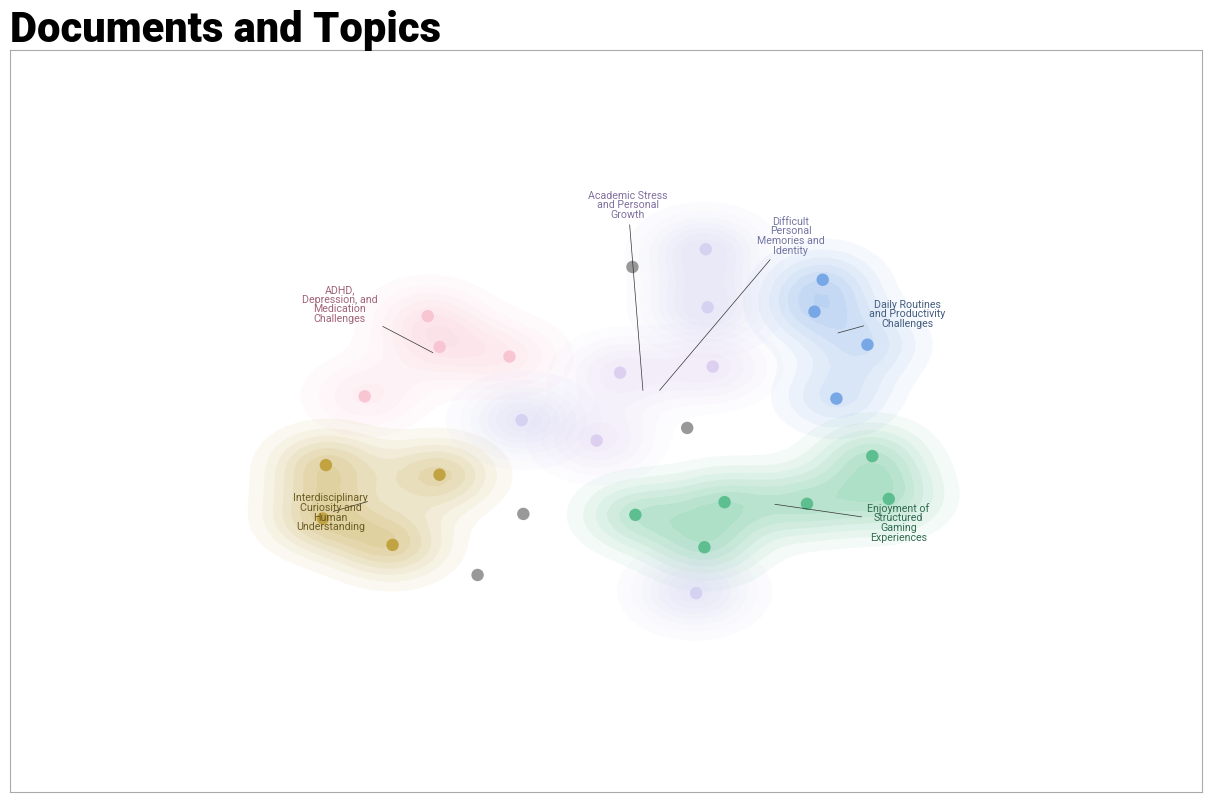

In [25]:
run_bertopic_viz(topic_model, df_group, output_folder, "Male_ADHD")

# Male non-ADHD

In [26]:
folder = next(f for f in folders if f.startswith("Male_noADHD_"))
print(folder)
df_group, topic_model, output_folder = preliminary_steps(folder)
check_hierarchy(topic_model, df_group, output_folder, "Male_noADHD")

Male_noADHD_20250818_135710_2
Running preliminary steps for folder: Male_noADHD_20250818_135710_2
Male_noADHD


100%|██████████| 7/7 [00:00<00:00, 493.30it/s]


🔧 Applying hierarchy specific optimizations...
🖼️  Saved bertopic_hierarchy_Male_noADHD as PNG: 20250826_234727_bertopic_hierarchy_male_noadhd.png
📊 Saved bertopic_hierarchy_Male_noADHD as HTML: 20250826_234727_bertopic_hierarchy_male_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_hierarchy_Male_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_results/Male_noADHD_20250818_135710_2
------------------------------------------------------------


🔧 Applying topics specific optimizations...
🖼️  Saved bertopic_topics_Male_noADHD as PNG: 20250826_234728_bertopic_topics_male_noadhd.png
📊 Saved bertopic_topics_Male_noADHD as HTML: 20250826_234728_bertopic_topics_male_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_Male_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_results/Male_noADHD_20250818_135710_2
------------------------------------------------------------


.
├─dia_fazer_porque_algo_hoje
│    ├─■──história_anime_geralmente_parte_escrita ── Topic: 7
│    └─dia_fazer_porque_algo_hoje
│         ├─dia_fazer_porque_hoje_algo
│         │    ├─■──jogos_desde_jogar_pequeno_gosto ── Topic: 2
│         │    └─dia_fazer_porque_ir_hoje
│         │         ├─■──dia_hoje_fazer_ir_porque ── Topic: 0
│         │         └─■──desporto_gosto_sentir_porque_poder ── Topic: 1
│         └─■──música_ouvir_gostos_gosto_bastante ── Topic: 4
└─escrever_detalhe_sinto confortável_confortável_sinto
     ├─escrever_detalhe_sinto confortável_confortável_sinto
     │    ├─■──escrever_detalhe_sinto confortável_confortável_sinto ── Topic: 3
     │    └─■──nada_cabeça_escrever__ ── Topic: 6
     └─■──aceite_causa___ ── Topic: 5



In [27]:
topic_info = topic_model.get_topic_info()
display(topic_info)
topic_info.to_csv(f"{output_folder}/topic_info.csv", index=False)

Topic  Count                                              Name  \
0      0     69                               0_dia_hoje_fazer_ir   
1      1     24                    1_desporto_gosto_sentir_porque   
2      2     12                       2_jogos_desde_jogar_pequeno   
3      3      8  3_escrever_detalhe_sinto confortável_confortável   
4      4      7                       4_música_ouvir_gostos_gosto   
5      5      6                                  5_aceite_causa__   
6      6      4                           6_nada_cabeça_escrever_   
7      7      3                 7_história_anime_geralmente_parte   

                                   CustomName  \
0             Daily Routines and Productivity   
1              Enjoyment of Sports Activities   
2                Passion for Game Development   
3      Discomfort Discussing Sensitive Topics   
4  Personal Music Preferences and Experiences   
5         Fire Brigade Leadership Appointment   
6                    Lack of Ideas or Content   
7    Emotional Connection to Anime Narratives   

                                      Representation  \
0  [dia, hoje, fazer, ir, porque, algo, tempo, ap...   
1  [desporto, gosto, sentir, porque, poder, posso...   
2  [jogos, desde, jogar, pequeno, gosto, sempre, ...   
3  [escrever, detalhe, sinto confortável, confort...   
4  [música, ouvir, gostos, gosto, bastante, prime...   
5                    [aceite, causa, , , , , , , , ]   
6             [nada, cabeça, escrever, , , , , , , ]   
7  [história, anime, geralmente, parte, escrita, ...   

                                             KeyBERT  \
0  [fiquei, comecei, senti, acabei, faço, altura,...   
1  [gosto jogar, gosto fazer, gostar tanto, gosto...   
2  [gosto jogar, game dev, jogos, programar, gost...   
3  [discutir, escrever, situações, pessoal, senti...   
4  [música, ouvir, sentir, sinto, emoções, sentir...   
5                               [, , , , , , , , , ]   
6             [nada, escrever, cabeça, , , , , , , ]   
7  [anime, história, magia, especial, gostar tant...   

                                         OpenAI  \
0             [Daily Routines and Productivity]   
1              [Enjoyment of Sports Activities]   
2                [Passion for Game Development]   
3      [Discomfort Discussing Sensitive Topics]   
4  [Personal Music Preferences and Experiences]   
5         [Fire Brigade Leadership Appointment]   
6                    [Lack of Ideas or Content]   
7    [Emotional Connection to Anime Narratives]   

                                                 MMR  \
0  [hoje, tempo, apesar, coisas, senti, melhor, v...   
1  [desporto, sentir, quero, especial, futebol, f...   
2  [jogos, gosto, aprender, cresci, desafio, cois...   
3  [escrever, detalhe, sinto confortável, mim, si...   
4  [música, gostos, primeira, outros, escrever, s...   
5  [aceite, causa, , , , , , , , , , , , , , , , ...   
6  [nada, cabeça, escrever, , , , , , , , , , , ,...   
7  [história, anime, escrita, hoje continuo, sent...   

                                                 POS  Representative_Docs  
0  [dia, tempo, coisas, amigos, melhor, vida, vez...                  NaN  
1  [desporto, gosto, poder, dia, melhor, especial...                  NaN  
2  [jogos, pequeno, gosto, desafio, maneira, cois...                  NaN  
3  [detalhe, confortável, situações, tipo, intere...                  NaN  
4  [música, gostos, gosto, primeira, momento, cab...                  NaN  
5                          [causa, , , , , , , , , ]                  NaN  
6                         [cabeça, , , , , , , , , ]                  NaN  
7  [história, anime, parte, escrita, sentido, fac...                  NaN

In [28]:
run_bertopic_evals(topic_model, df_group, output_folder)

Silhouette score calculated on 133 documents across 8 topics
Silhouette Score: 0.0696
Calculating topic coherence using UMass metric...
Vectorizer available!
Average Topic Coherence (UMass): -1.1152
Individual Topic Coherences:
  Topic 0: -1.2916
  Topic 1: -1.5483
  Topic 2: -1.4993
  Topic 3: -1.4115
  Topic 4: -1.1671
  Topic 5: 0.0000
  Topic 6: -1.4102
  Topic 7: -0.5934
Coherence results saved to ../../outputs/bertopic_results/Male_noADHD_20250818_135710_2/


Number of texts: 133
Number of topics: 133


Document  Topic  \
0    Senhor dos anéis pelo expansivo mundo, históri...      1   
1    Jogos no geral, adoro aprender e perceber mecâ...      2   
2    Música e como certos sons e instrumentos me fa...      4   
3    Video jogos, independentemente do género, gost...      2   
4       Adivinhar os dias da semana com base numa data      0   
..                                                 ...    ...   
128                                                  .      5   
129  Existem primatas que usam utensílios básicos c...      1   
130  Quero dormir. Quero deitar-me numa cama e apag...      1   
131  Física quântica para mim é super interessante ...      1   
132  Outras características minhas que possam ser r...      0   

                               Name  \
0    1_desporto_gosto_sentir_porque   
1       2_jogos_desde_jogar_pequeno   
2       4_música_ouvir_gostos_gosto   
3       2_jogos_desde_jogar_pequeno   
4               0_dia_hoje_fazer_ir   
..                              ...   
128                5_aceite_causa__   
129  1_desporto_gosto_sentir_porque   
130  1_desporto_gosto_sentir_porque   
131  1_desporto_gosto_sentir_porque   
132             0_dia_hoje_fazer_ir   

                                     CustomName  \
0                Enjoyment of Sports Activities   
1                  Passion for Game Development   
2    Personal Music Preferences and Experiences   
3                  Passion for Game Development   
4               Daily Routines and Productivity   
..                                          ...   
128         Fire Brigade Leadership Appointment   
129              Enjoyment of Sports Activities   
130              Enjoyment of Sports Activities   
131              Enjoyment of Sports Activities   
132             Daily Routines and Productivity   

                                        Representation  \
0    [desporto, gosto, sentir, porque, poder, posso...   
1    [jogos, desde, jogar, pequeno, gosto, sempre, ...   
2    [música, ouvir, gostos, gosto, bastante, prime...   
3    [jogos, desde, jogar, pequeno, gosto, sempre, ...   
4    [dia, hoje, fazer, ir, porque, algo, tempo, ap...   
..                                                 ...   
128                    [aceite, causa, , , , , , , , ]   
129  [desporto, gosto, sentir, porque, poder, posso...   
130  [desporto, gosto, sentir, porque, poder, posso...   
131  [desporto, gosto, sentir, porque, poder, posso...   
132  [dia, hoje, fazer, ir, porque, algo, tempo, ap...   

                                               KeyBERT  \
0    [gosto jogar, gosto fazer, gostar tanto, gosto...   
1    [gosto jogar, game dev, jogos, programar, gost...   
2    [música, ouvir, sentir, sinto, emoções, sentir...   
3    [gosto jogar, game dev, jogos, programar, gost...   
4    [fiquei, comecei, senti, acabei, faço, altura,...   
..                                                 ...   
128                               [, , , , , , , , , ]   
129  [gosto jogar, gosto fazer, gostar tanto, gosto...   
130  [gosto jogar, gosto fazer, gostar tanto, gosto...   
131  [gosto jogar, gosto fazer, gostar tanto, gosto...   
132  [fiquei, comecei, senti, acabei, faço, altura,...   

                                           OpenAI  \
0                [Enjoyment of Sports Activities]   
1                  [Passion for Game Development]   
2    [Personal Music Preferences and Experiences]   
3                  [Passion for Game Development]   
4               [Daily Routines and Productivity]   
..                                            ...   
128         [Fire Brigade Leadership Appointment]   
129              [Enjoyment of Sports Activities]   
130              [Enjoyment of Sports Activities]   
131              [Enjoyment of Sports Activities]   
132             [Daily Routines and Productivity]   

                                                   MMR  \
0    [desporto, sentir, quero, especial, futebol, f...   
1    [jogos, gosto, aprender, cresci

🔧 Applying heatmap specific optimizations...
🖼️  Saved bertopic_heatmap_Male_noADHD as PNG: 20250826_234730_bertopic_heatmap_male_noadhd.png
📊 Saved bertopic_heatmap_Male_noADHD as HTML: 20250826_234730_bertopic_heatmap_male_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_heatmap_Male_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_results/Male_noADHD_20250818_135710_2
------------------------------------------------------------


4it [00:00, 195.42it/s]

🔧 Applying topics_per_class specific optimizations...


🖼️  Saved bertopic_topics_per_class_Male_noADHD as PNG: 20250826_234732_bertopic_topics_per_class_male_noadhd.png
📊 Saved bertopic_topics_per_class_Male_noADHD as HTML: 20250826_234732_bertopic_topics_per_class_male_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_per_class_Male_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_results/Male_noADHD_20250818_135710_2
------------------------------------------------------------


🖼️  Saved bertopic_document_datamap_Male_noADHD as PNG: 20250826_234735_bertopic_document_datamap_male_noadhd.png
📊 Saved bertopic_document_datamap_Male_noADHD as HTML: 20250826_234735_bertopic_document_datamap_male_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_document_datamap_Male_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_results/Male_noADHD_20250818_135710_2
------------------------------------------------------------


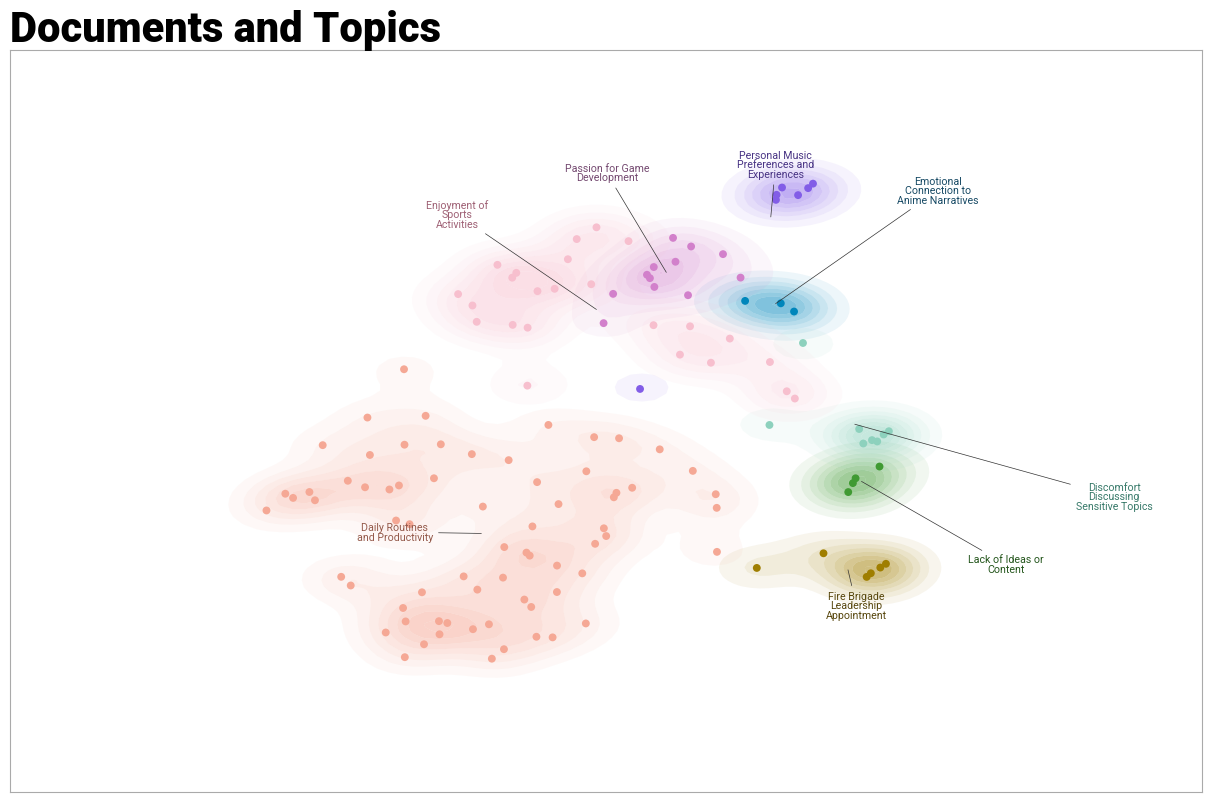

Translating topic words to English...

Translated Topics (Portuguese → English):
Topic 0: day, today, to do, go, why
Topic 1: sport, I like, to feel, why, power
Topic 2: games, since, to play, small, I like
Topic 3: to write, detail, I feel comfortable, comfortable, I feel
Topic 4: music, to hear, taste, I like, quite
Topic 5: acceptance, cause, , , 
Topic 6: nothing, head, to write, , 
Topic 7: history, anime, generally, part, writing
DEBUG: Available topics for plotting: [0, 1, 2, 3, 4, 5]
DEBUG: Topic 0 -> Label: Daily Routines and Productivity
DEBUG: Topic 1 -> Label: Enjoyment of Sports Activities
DEBUG: Topic 2 -> Label: Passion for Game Development
DEBUG: Topic 3 -> Label: Discomfort Discussing Sensitive Topics
DEBUG: Topic 4 -> Label: Personal Music Preferences and Experiences
DEBUG: Topic 5 -> Label: Fire Brigade Leadership Appointment
🔧 Applying translated_barchart specific optimizations...
🖼️  Saved bertopic_translated_barchart_Male_noADHD as PNG: 20250826_234750_bertopic_tr

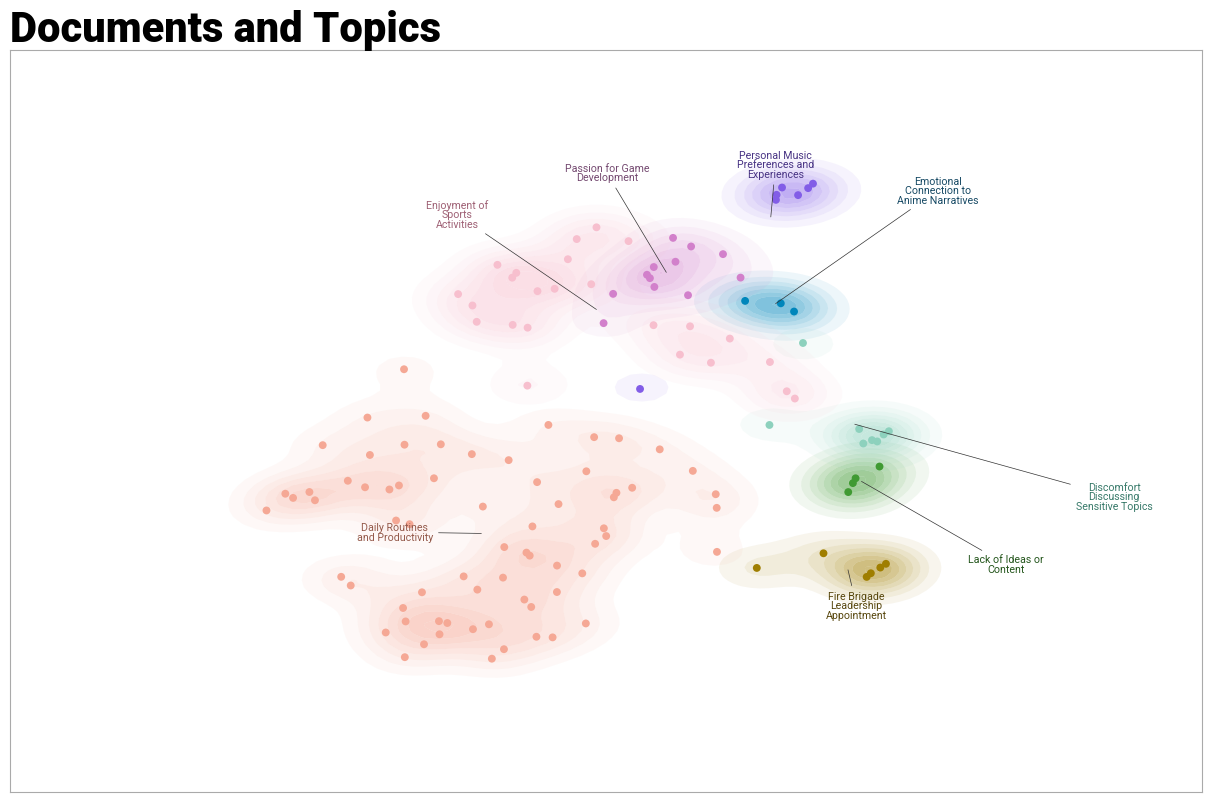

In [29]:
run_bertopic_viz(topic_model, df_group, output_folder, "Male_noADHD")

# Female

In [30]:
folder = next(f for f in folders if f.startswith("Female_2"))
print(folder)
df_group, topic_model, output_folder = preliminary_steps(folder)
check_hierarchy(topic_model, df_group, output_folder, "Female")

Female_20250818_135710_2
Running preliminary steps for folder: Female_20250818_135710_2
Female


100%|██████████| 13/13 [00:00<00:00, 494.49it/s]


🔧 Applying hierarchy specific optimizations...
🖼️  Saved bertopic_hierarchy_Female as PNG: 20250826_234755_bertopic_hierarchy_female.png
📊 Saved bertopic_hierarchy_Female as HTML: 20250826_234755_bertopic_hierarchy_female.html
✅ Total saved: 2 file(s) for 'bertopic_hierarchy_Female'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_results/Female_20250818_135710_2
------------------------------------------------------------


🔧 Applying topics specific optimizations...
🖼️  Saved bertopic_topics_Female as PNG: 20250826_234756_bertopic_topics_female.png
📊 Saved bertopic_topics_Female as HTML: 20250826_234756_bertopic_topics_female.html
✅ Total saved: 2 file(s) for 'bertopic_topics_Female'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_results/Female_20250818_135710_2
------------------------------------------------------------


.
├─dia_fazer_porque_hoje_ainda
│    ├─■──feliz_hoje_base_projeto_fazer ── Topic: 11
│    └─dia_fazer_porque_ainda_hoje
│         ├─dia_ainda_porque_fazer_hoje
│         │    ├─■──lembro_memória_mãe_anos_nunca ── Topic: 0
│         │    └─■──dia_fazer_ir_ainda_hoje ── Topic: 1
│         └─■──trabalho_fazer_dia_semana_cansada ── Topic: 3
└─gosto_música_adoro_pessoas_animais
     ├─gosto_música_adoro_pessoas_animais
     │    ├─animais_pessoas_phda_gatos_animal
     │    │    ├─■──animais_gatos_animal_serem_24 ── Topic: 13
     │    │    └─pessoas_phda_social_pois_parte
     │    │         ├─■──phda_pessoas_pois_gostaria_gostava ── Topic: 6
     │    │         └─■──justiça_mental_social_ajudar_filosofia ── Topic: 9
     │    └─gosto_música_adoro_ler_interesse
     │         ├─gosto_música_ler_interesse_adoro
     │         │    ├─■──gosto_utilizar_acesso_artista_estando ── Topic: 12
     │         │    └─gosto_música_ler_interesse_adoro
     │         │         ├─gosto_ler_interesse_ador

In [31]:
topic_info = topic_model.get_topic_info()
display(topic_info)
topic_info.to_csv(f"{output_folder}/topic_info.csv", index=False)

Topic  Count                                        Name  \
0      -1     56                  -1_dia_voltar_pessoas_casa   
1       0     70                   0_lembro_memória_mãe_anos   
2       1     37                        1_dia_fazer_ir_ainda   
3       2     28                2_ler_forma_interesse_porque   
4       3     12                 3_trabalho_fazer_dia_semana   
5       4     12          4_conhecer_viajar_sentir_liberdade   
6       5     11                5_música_ouvir_tocar_consigo   
7       6     10                6_phda_pessoas_pois_gostaria   
8       7      9                7_cozinhar_permite_adoro_cor   
9       8      8        8_gosto_interesse_alimentação_física   
10      9      8              9_justiça_mental_social_ajudar   
11     10      7  10_prefiro_portugal_eleições_prefiro fazer   
12     11      7                  11_feliz_hoje_base_projeto   
13     12      5            12_gosto_utilizar_acesso_artista   
14     13      5               13_animais_gatos_animal_serem   

                                    CustomName  \
0                                Outlier Topic   
1   Friendship, Identity, and Social Exclusion   
2       Daily Routines and Personal Challenges   
3       Personal Reading Interests and Fandoms   
4                      Work Stress and Fatigue   
5                Travel, Nature, and Discovery   
6                    Music as Emotional Escape   
7      Neurodiversity, Feminism, Social Stigma   
8          Relaxing Creative Manual Activities   
9           Personal Interests and Preferences   
10            Social Justice and Mental Health   
11         Uncertainty About Portugal’s Future   
12           Daily Life and Personal Wellbeing   
13     Personal Creative Expression and Design   
14      Animal Welfare and Human Relationships   

                                       Representation  \
0   [dia, voltar, pessoas, casa, mim, momento, vez...   
1   [lembro, memória, mãe, anos, nunca, tudo, mim,...   
2   [dia, fazer, ir, ainda, hoje, acordei, pai, po...   
3   [ler, forma, interesse, porque, gosto, comecei...   
4   [trabalho, fazer, dia, semana, cansada, tempo,...   
5   [conhecer, viajar, sentir, liberdade, novas, m...   
6   [música, ouvir, tocar, consigo, vida, enquanto...   
7   [phda, pessoas, pois, gostaria, gostava, mulhe...   
8   [cozinhar, permite, adoro, cor, porque, acalma...   
9   [gosto, interesse, alimentação, física, coisas...   
10  [justiça, mental, social, ajudar, filosofia, a...   
11  [prefiro, portugal, eleições, prefiro fazer, f...   
12  [feliz, hoje, base, projeto, fazer, trabalho, ...   
13  [gosto, utilizar, acesso, artista, estando, ac...   
14  [animais, gatos, animal, serem, 24, tendência,...   

                                              KeyBERT  \
0   [fiquei, mim, senti, ir, fazer, vezes, sair, a...   
1   [conheci, senti, ansiedade, passei, comigo, al...   
2   [hoje acordei, acordei, comecei, fiquei, passe...   
3   [ler, mitologia, tópico, escrita, lido, saga, ...   
4   [trabalho senti, stress, quero dormir, bom aco...   
5   [viajar, adoro conhecer, viver, passear, senti...   
6   [musicais, música, musical, tocar, normalmente...   
7   [feminismo, políticas, diagnosticado, porque p...   
8   [fazer coisas, fazer, cozinhar, porque gosto, ...   
9   [muitas coisas, adoro conhecer, interesses, in...   
10  [social, saúde mental, psicologia, justiça soc...   
11  [prefiro fazer, prefiro, medo, fazer, acho, re...   
12  [trabalho senti, faço, fazer, fazer trabalho, ...   
13  [motivos estéticos, criatividade, estéticos, c...   
14  [animais, amo, carinho, animal, amor, gatos, p...   

                                          OpenAI  \
0          [Impactful Childhood and Life Events]   
1   [Friendship, Identity, and Social Exclusion]   
2       [Daily Routines and Personal Challenges]   
3       [Personal Reading Interests and Fandoms]   
4                      [Work Stress and Fatigue]   
5                [Travel, Nature, and Di

In [32]:
run_bertopic_evals(topic_model, df_group, output_folder)

Silhouette score calculated on 229 documents across 14 topics
Silhouette Score: 0.0217
Calculating topic coherence using UMass metric...
Vectorizer available!
Average Topic Coherence (UMass): -1.2943
Individual Topic Coherences:
  Topic 0: -1.1351
  Topic 1: -1.3145
  Topic 2: -1.6375
  Topic 3: -1.7413
  Topic 4: -1.3935
  Topic 5: -1.2865
  Topic 6: -1.7191
  Topic 7: -1.0053
  Topic 8: -1.4815
  Topic 9: -1.1326
  Topic 10: -1.1201
  Topic 11: -1.3972
  Topic 12: -1.0481
  Topic 13: -0.7081
Coherence results saved to ../../outputs/bertopic_results/Female_20250818_135710_2/


Number of texts: 285
Number of topics: 285


Document  Topic  \
0    Adoro cozinhar, porque sinto que é a forma ide...      7   
1    Gosto de ver séries porque relatam relações sa...      2   
2    Campos de ferias. Temos que criar o campo todo...     -1   
3    Taylor Swift, amo o seu liricismo e a maneira ...     -1   
4    Historia da arte \nÉ só tão interessante. Para...     -1   
..                                                 ...    ...   
280  Maiores dificuldades que sempre senti.. Concen...     -1   
281  O ponto em que sociedade se está a tornar,: eg...     -1   
282  Gostava que não dissessem : toda a gente tem p...      6   
283  Não sei explicar o que se anda a passar comigo...     -1   
284  Alguém me mande um milagre, I am going crazy, ...      1   

                             Name                               CustomName  \
0    7_cozinhar_permite_adoro_cor      Relaxing Creative Manual Activities   
1    2_ler_forma_interesse_porque   Personal Reading Interests and Fandoms   
2      -1_dia_voltar_pessoas_casa                            Outlier Topic   
3      -1_dia_voltar_pessoas_casa                            Outlier Topic   
4      -1_dia_voltar_pessoas_casa                            Outlier Topic   
..                            ...                                      ...   
280    -1_dia_voltar_pessoas_casa                            Outlier Topic   
281    -1_dia_voltar_pessoas_casa                            Outlier Topic   
282  6_phda_pessoas_pois_gostaria  Neurodiversity, Feminism, Social Stigma   
283    -1_dia_voltar_pessoas_casa                            Outlier Topic   
284          1_dia_fazer_ir_ainda   Daily Routines and Personal Challenges   

                                        Representation  \
0    [cozinhar, permite, adoro, cor, porque, acalma...   
1    [ler, forma, interesse, porque, gosto, comecei...   
2    [dia, voltar, pessoas, casa, mim, momento, vez...   
3    [dia, voltar, pessoas, casa, mim, momento, vez...   
4    [dia, voltar, pessoas, casa, mim, momento, vez...   
..                                                 ...   
280  [dia, voltar, pessoas, casa, mim, momento, vez...   
281  [dia, voltar, pessoas, casa, mim, momento, vez...   
282  [phda, pessoas, pois, gostaria, gostava, mulhe...   
283  [dia, voltar, pessoas, casa, mim, momento, vez...   
284  [dia, fazer, ir, ainda, hoje, acordei, pai, po...   

                                               KeyBERT  \
0    [fazer coisas, fazer, cozinhar, porque gosto, ...   
1    [ler, mitologia, tópico, escrita, lido, saga, ...   
2    [fiquei, mim, senti, ir, fazer, vezes, sair, a...   
3    [fiquei, mim, senti, ir, fazer, vezes, sair, a...   
4    [fiquei, mim, senti, ir, fazer, vezes, sair, a...   
..                                                 ...   
280  [fiquei, mim, senti, ir, fazer, vezes, sair, a...   
281  [fiquei, mim, senti, ir, fazer, vezes, sair, a...   
282  [feminismo, políticas, diagnosticado, porque p...   
283  [fiquei, mim, senti, ir, fazer, vezes, sair, a...   
284  [hoje acordei, acordei, comecei, fiquei, passe...   

                                        OpenAI  \
0        [Relaxing Creative Manual Activities]   
1     [Personal Reading Interests and Fandoms]   
2        [Impactful Childhood and Life Events]   
3        [Impactful Childhood and Life Events]   
4        [Impactful Childhood and Life Events]   
..                                         ...   
280      [Impactful Childhood and Life Events]   
281      [Impactful Childhood and Life Events]   
282  [Neurodiversity, Feminism, Social Stigma]   
283      [Impactful Childhood and Life Events]   
284   [Daily Routines and Personal Challenges]   

                                                   MMR  \
0    [cozinhar, cor, fazer, especialmente, ficar fo...   
1    [ler, gosto, personagens, interesse especial, ...   
2    [voltar, mim, vezes, músicas, hoje, teatro, pe...   
3    [voltar, mim, vezes, músicas, hoje, teatro, pe...   
4    [voltar, mim, vezes, músicas, hoje, te

🔧 Applying heatmap specific optimizations...
🖼️  Saved bertopic_heatmap_Female as PNG: 20250826_234758_bertopic_heatmap_female.png
📊 Saved bertopic_heatmap_Female as HTML: 20250826_234758_bertopic_heatmap_female.html
✅ Total saved: 2 file(s) for 'bertopic_heatmap_Female'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_results/Female_20250818_135710_2
------------------------------------------------------------


4it [00:00, 109.63it/s]

🔧 Applying topics_per_class specific optimizations...


🖼️  Saved bertopic_topics_per_class_Female as PNG: 20250826_234800_bertopic_topics_per_class_female.png
📊 Saved bertopic_topics_per_class_Female as HTML: 20250826_234800_bertopic_topics_per_class_female.html
✅ Total saved: 2 file(s) for 'bertopic_topics_per_class_Female'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_results/Female_20250818_135710_2
------------------------------------------------------------


🖼️  Saved bertopic_document_datamap_Female as PNG: 20250826_234803_bertopic_document_datamap_female.png
📊 Saved bertopic_document_datamap_Female as HTML: 20250826_234803_bertopic_document_datamap_female.html
✅ Total saved: 2 file(s) for 'bertopic_document_datamap_Female'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_results/Female_20250818_135710_2
------------------------------------------------------------


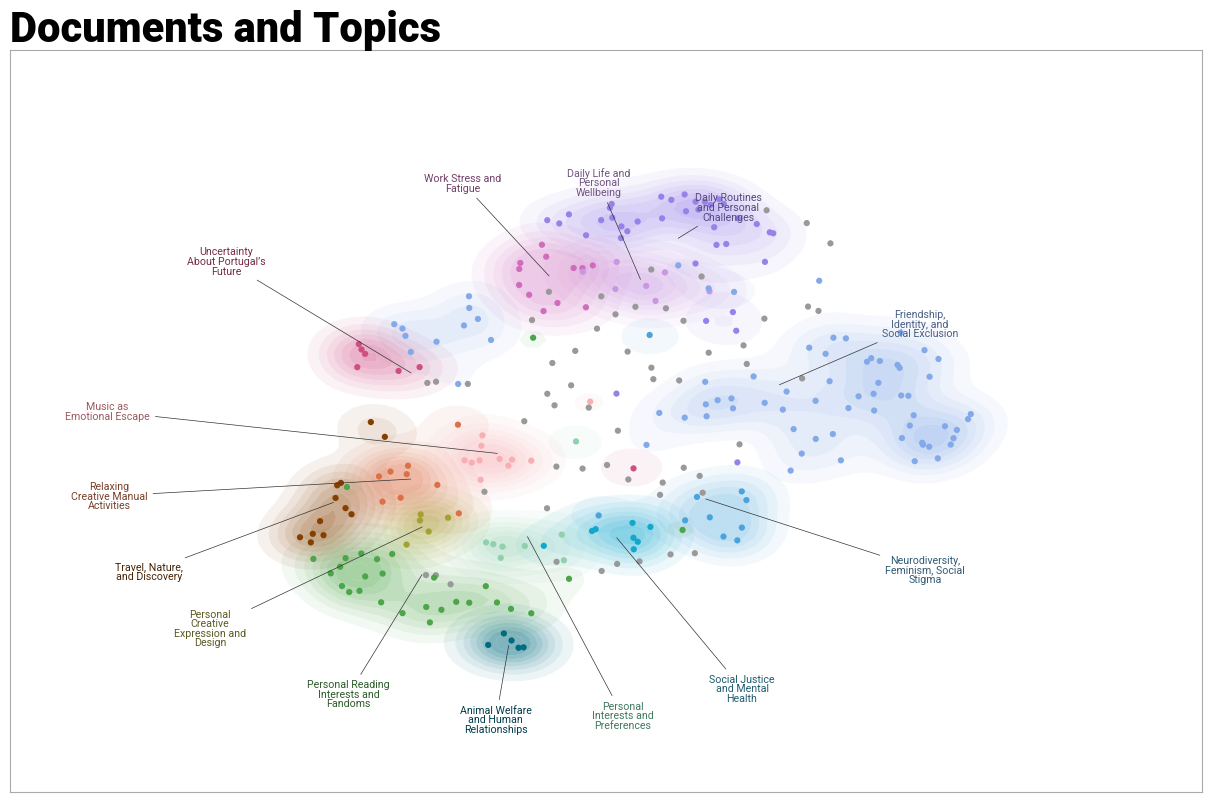

Translating topic words to English...

Translated Topics (Portuguese → English):
Topic 0: I remember, memory, mother, years, never
Topic 1: day, to do, go, yet, today
Topic 2: to read, shape, interest, why, I like
Topic 3: work, to do, day, week, tired
Topic 4: to know, travel, to feel, freedom, new
Topic 5: music, to hear, touch, with you, life
Topic 6: adhd, people, then, I would like, liked
Topic 7: to cook, allow, I adore, color, why
Topic 8: I like, interest, food, physical, things
Topic 9: justice, mental, social, to help, philosophy
Topic 10: I prefer, Portugal, elections, I prefer to do, future
Topic 11: happy, today, base, project, to do
Topic 12: I like, use, access, artist, being
Topic 13: animals, cats, animal, be, 24
DEBUG: Available topics for plotting: [0, 1, 2, 3, 4, 5]
DEBUG: Topic 0 -> Label: Friendship, Identity, and Social Exclusion
DEBUG: Topic 1 -> Label: Daily Routines and Personal Challenges
DEBUG: Topic 2 -> Label: Personal Reading Interests and Fandoms
DEBUG: 

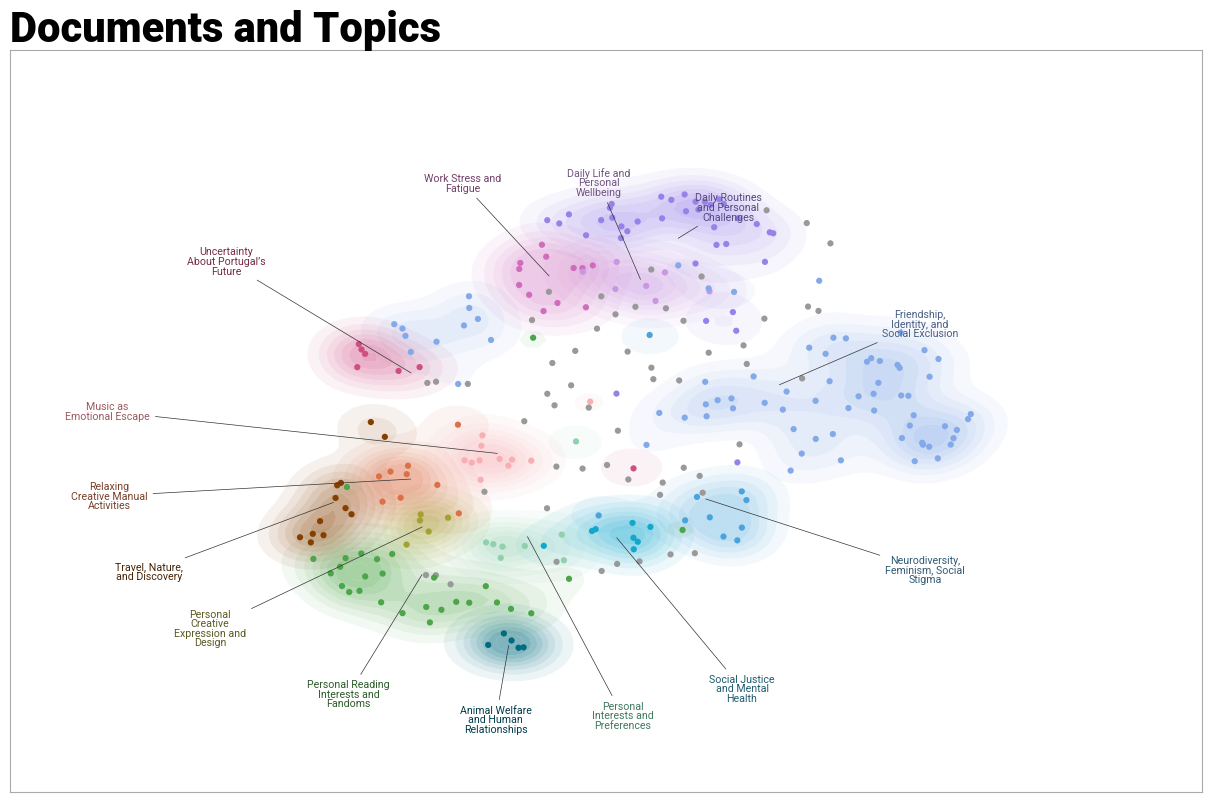

In [33]:
run_bertopic_viz(topic_model, df_group, output_folder, "Female")

# Male

In [34]:
folder = next(f for f in folders if f.startswith("Male_2"))
print(folder)
df_group, topic_model, output_folder = preliminary_steps(folder)
check_hierarchy(topic_model, df_group, output_folder, "Male")

Male_20250818_135710_2
Running preliminary steps for folder: Male_20250818_135710_2
Male


100%|██████████| 12/12 [00:00<00:00, 545.29it/s]


🔧 Applying hierarchy specific optimizations...
🖼️  Saved bertopic_hierarchy_Male as PNG: 20250826_234838_bertopic_hierarchy_male.png
📊 Saved bertopic_hierarchy_Male as HTML: 20250826_234838_bertopic_hierarchy_male.html
✅ Total saved: 2 file(s) for 'bertopic_hierarchy_Male'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_results/Male_20250818_135710_2
------------------------------------------------------------


🔧 Applying topics specific optimizations...
🖼️  Saved bertopic_topics_Male as PNG: 20250826_234840_bertopic_topics_male.png
📊 Saved bertopic_topics_Male as HTML: 20250826_234840_bertopic_topics_male.html
✅ Total saved: 2 file(s) for 'bertopic_topics_Male'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_results/Male_20250818_135710_2
------------------------------------------------------------


.
├─dia_fazer_hoje_porque_algo
│    ├─jogos_jogo_sempre_fazer_video
│    │    ├─■──jogo_auto_dia trabalho_existe_online ── Topic: 11
│    │    └─■──jogos_desde_desde pequeno_cresci_outras pessoas ── Topic: 10
│    └─dia_hoje_porque_fazer_ir
│         ├─dia_hoje_porque_fazer_ir
│         │    ├─história_anime_mundo_interesse_geralmente
│         │    │    ├─■──história_anime_geralmente_parte_interesse especial ── Topic: 7
│         │    │    └─■──saber_técnicas_porquê_valores_aprendizagem ── Topic: 8
│         │    └─dia_porque_hoje_fazer_ir
│         │         ├─desporto_sentir_adoro_aprecio_gosto fazer
│         │         │    ├─■──sentir_pensamentos_sozinho_posso_jogar ── Topic: 6
│         │         │    └─■──desporto_momentos_futebol_poder_qualquer ── Topic: 12
│         │         └─hoje_dia_porque_ir_fazer
│         │              ├─hoje_dia_porque_ir_fazer
│         │              │    ├─■──anos_pai_memória_antes_futebol ── Topic: 1
│         │              │    └─■──dia_ir_tarde

In [35]:
topic_info = topic_model.get_topic_info()
display(topic_info)
topic_info.to_csv(f"{output_folder}/topic_info.csv", index=False)

Topic  Count                                              Name  \
0      -1     17                      -1_gosto_tipo_melhorar_sinto   
1       0     62                              0_dia_ir_tarde_fazer   
2       1     24                          1_anos_pai_memória_antes   
3       2      7  2_escrever_sinto confortável_detalhe_confortável   
4       3      7                                3_14_causa_aceite_   
5       4      7                       4_música_ouvir_gostos_gosto   
6       5      6                 5_constante_capacidade_usar_outra   
7       6      5                6_sentir_pensamentos_sozinho_posso   
8       7      5                 7_história_anime_geralmente_parte   
9       8      5                   8_saber_técnicas_porquê_valores   
10      9      5            9_nada_lembrar_genuinamente_importante   
11     10      4               10_jogos_desde_desde pequeno_cresci   
12     11      4                  11_jogo_auto_dia trabalho_existe   
13     12      4                12_desporto_momentos_futebol_poder   

                                      CustomName  \
0                                  Outlier Topic   
1                Daily Productivity and Routines   
2          Childhood Memories and Life Decisions   
3         Discomfort Discussing Sensitive Topics   
4              Linux and Firefighting Leadership   
5     Personal Music Preferences and Experiences   
6             Human and Animal Social Complexity   
7                        Sports as Mental Escape   
8         Emotional Connections to Fantasy Media   
9   Exploring Knowledge, Science, and Techniques   
10                   Memory Lapses and Emptiness   
11             Video Game Development Enthusiasm   
12           Competitive and Social Video Gaming   
13                Passion for Sports and Cooking   

                                       Representation  \
0   [gosto, tipo, melhorar, sinto, algo, filme, ve...   
1   [dia, ir, tarde, fazer, hoje, porque, tempo, a...   
2   [anos, pai, memória, antes, futebol, ainda, ho...   
3   [escrever, sinto confortável, detalhe, confort...   
4                   [14, causa, aceite, , , , , , , ]   
5   [música, ouvir, gostos, gosto, bastante, prime...   
6   [constante, capacidade, usar, outra, qualquer,...   
7   [sentir, pensamentos, sozinho, posso, jogar, a...   
8   [história, anime, geralmente, parte, interesse...   
9   [saber, técnicas, porquê, valores, aprendizage...   
10  [nada, lembrar, genuinamente, importante, tão,...   
11  [jogos, desde, desde pequeno, cresci, outras p...   
12  [jogo, auto, dia trabalho, existe, online, qua...   
13  [desporto, momentos, futebol, poder, qualquer,...   

                                              KeyBERT  \
0   [melhorar, criar, faz gostar, faz, torna, nome...   
1   [comecei, fiquei, faço, fiz, acabei, senti, te...   
2   [memória, momentos, sentimento, mim, emoções, ...   
3   [escrever, discutir, situações, pessoal, sinto...   
4                                [, , , , , , , , , ]   
5   [ouvir música, música, ouvir, sentir, sinto, e...   
6   [mexer, fazer, usar, humanos, constante, socie...   
7   [gosto fazer, praticar, mim, jogar, desporto, ...   
8   [histórias, história, livro, emocional, anime,...   
9   [várias técnicas, técnicas, aprendizagem, teor...   
10  [nada, tão, escrever, lembrar, importante, cab...   
11  [videojogos, video jogos, jogos, game dev, pro...   
12  [jogar videojogos, videojogos, video jogos, jo...   
13  [gosto fazer, desafiantes, faço, adoro, apreci...   

                                            OpenAI  \
0             [Personal Interests and Improvement]   
1                [Daily Productivity and Routines]   
2          [Childhood Memories and Life Decisions]   
3         [Discomfort Discussing Sensitive Topics]   
4              [Linux and Firefighting Leadership]   
5     [Personal Music Preferences and Experiences]   
6             [Human and Animal Social Complexity]   
7                        [Sp

In [36]:
run_bertopic_evals(topic_model, df_group, output_folder)

Silhouette score calculated on 145 documents across 13 topics
Silhouette Score: 0.0643
Calculating topic coherence using UMass metric...
Vectorizer available!
Average Topic Coherence (UMass): -1.0585
Individual Topic Coherences:
  Topic 0: -1.2766
  Topic 1: -1.2369
  Topic 2: -1.3827
  Topic 3: 0.0000
  Topic 4: -1.1018
  Topic 5: -1.1760
  Topic 6: -1.2615
  Topic 7: -0.8950
  Topic 8: -0.9831
  Topic 9: -1.0638
  Topic 10: -1.0160
  Topic 11: -0.8155
  Topic 12: -1.5513
Coherence results saved to ../../outputs/bertopic_results/Male_20250818_135710_2/


Number of texts: 162
Number of topics: 162


Document  Topic  \
0    Senhor dos anéis pelo expansivo mundo, históri...     -1   
1    Jogos no geral, adoro aprender e perceber mecâ...     10   
2    Música e como certos sons e instrumentos me fa...      4   
3    Video jogos, independentemente do género, gost...     11   
4       Adivinhar os dias da semana com base numa data      0   
..                                                 ...    ...   
157  Existem primatas que usam utensílios básicos c...      5   
158  Quero dormir. Quero deitar-me numa cama e apag...      0   
159  Física quântica para mim é super interessante ...      8   
160  Outras características minhas que possam ser r...      0   
161  De momento, na minha cabeça, só rumino sobre o...      0   

                                    Name  \
0           -1_gosto_tipo_melhorar_sinto   
1    10_jogos_desde_desde pequeno_cresci   
2            4_música_ouvir_gostos_gosto   
3       11_jogo_auto_dia trabalho_existe   
4                   0_dia_ir_tarde_fazer   
..                                   ...   
157    5_constante_capacidade_usar_outra   
158                 0_dia_ir_tarde_fazer   
159      8_saber_técnicas_porquê_valores   
160                 0_dia_ir_tarde_fazer   
161                 0_dia_ir_tarde_fazer   

                                       CustomName  \
0                                   Outlier Topic   
1               Video Game Development Enthusiasm   
2      Personal Music Preferences and Experiences   
3             Competitive and Social Video Gaming   
4                 Daily Productivity and Routines   
..                                            ...   
157            Human and Animal Social Complexity   
158               Daily Productivity and Routines   
159  Exploring Knowledge, Science, and Techniques   
160               Daily Productivity and Routines   
161               Daily Productivity and Routines   

                                        Representation  \
0    [gosto, tipo, melhorar, sinto, algo, filme, ve...   
1    [jogos, desde, desde pequeno, cresci, outras p...   
2    [música, ouvir, gostos, gosto, bastante, prime...   
3    [jogo, auto, dia trabalho, existe, online, qua...   
4    [dia, ir, tarde, fazer, hoje, porque, tempo, a...   
..                                                 ...   
157  [constante, capacidade, usar, outra, qualquer,...   
158  [dia, ir, tarde, fazer, hoje, porque, tempo, a...   
159  [saber, técnicas, porquê, valores, aprendizage...   
160  [dia, ir, tarde, fazer, hoje, porque, tempo, a...   
161  [dia, ir, tarde, fazer, hoje, porque, tempo, a...   

                                               KeyBERT  \
0    [melhorar, criar, faz gostar, faz, torna, nome...   
1    [videojogos, video jogos, jogos, game dev, pro...   
2    [ouvir música, música, ouvir, sentir, sinto, e...   
3    [jogar videojogos, videojogos, video jogos, jo...   
4    [comecei, fiquei, faço, fiz, acabei, senti, te...   
..                                                 ...   
157  [mexer, fazer, usar, humanos, constante, socie...   
158  [comecei, fiquei, faço, fiz, acabei, senti, te...   
159  [várias técnicas, técnicas, aprendizagem, teor...   
160  [comecei, fiquei, faço, fiz, acabei, senti, te...   
161  [comecei, fiquei, faço, fiz, acabei, senti, te...   

                                             OpenAI  \
0              [Personal Interests and Improvement]   
1               [Video Game Development Enthusiasm]   
2      [Personal Music Preferences and Experiences]   
3             [Competitive and Social Video Gaming]   
4                 [Daily Productivity and Routines]   
..                                              ...   
157            [Human and Animal Social Complexity]   
158               [Daily Productivity and Routines]   
159  [Exploring Knowledge, Science, and Techniques]   
160               [Daily Productivity and Routines]   
161               [Daily Productivity and Routines]   

                                            

🔧 Applying heatmap specific optimizations...
🖼️  Saved bertopic_heatmap_Male as PNG: 20250826_234841_bertopic_heatmap_male.png
📊 Saved bertopic_heatmap_Male as HTML: 20250826_234841_bertopic_heatmap_male.html
✅ Total saved: 2 file(s) for 'bertopic_heatmap_Male'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_results/Male_20250818_135710_2
------------------------------------------------------------


4it [00:00, 164.10it/s]

🔧 Applying topics_per_class specific optimizations...


🖼️  Saved bertopic_topics_per_class_Male as PNG: 20250826_234843_bertopic_topics_per_class_male.png
📊 Saved bertopic_topics_per_class_Male as HTML: 20250826_234843_bertopic_topics_per_class_male.html
✅ Total saved: 2 file(s) for 'bertopic_topics_per_class_Male'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_results/Male_20250818_135710_2
------------------------------------------------------------


🖼️  Saved bertopic_document_datamap_Male as PNG: 20250826_234846_bertopic_document_datamap_male.png
📊 Saved bertopic_document_datamap_Male as HTML: 20250826_234846_bertopic_document_datamap_male.html
✅ Total saved: 2 file(s) for 'bertopic_document_datamap_Male'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_results/Male_20250818_135710_2
------------------------------------------------------------


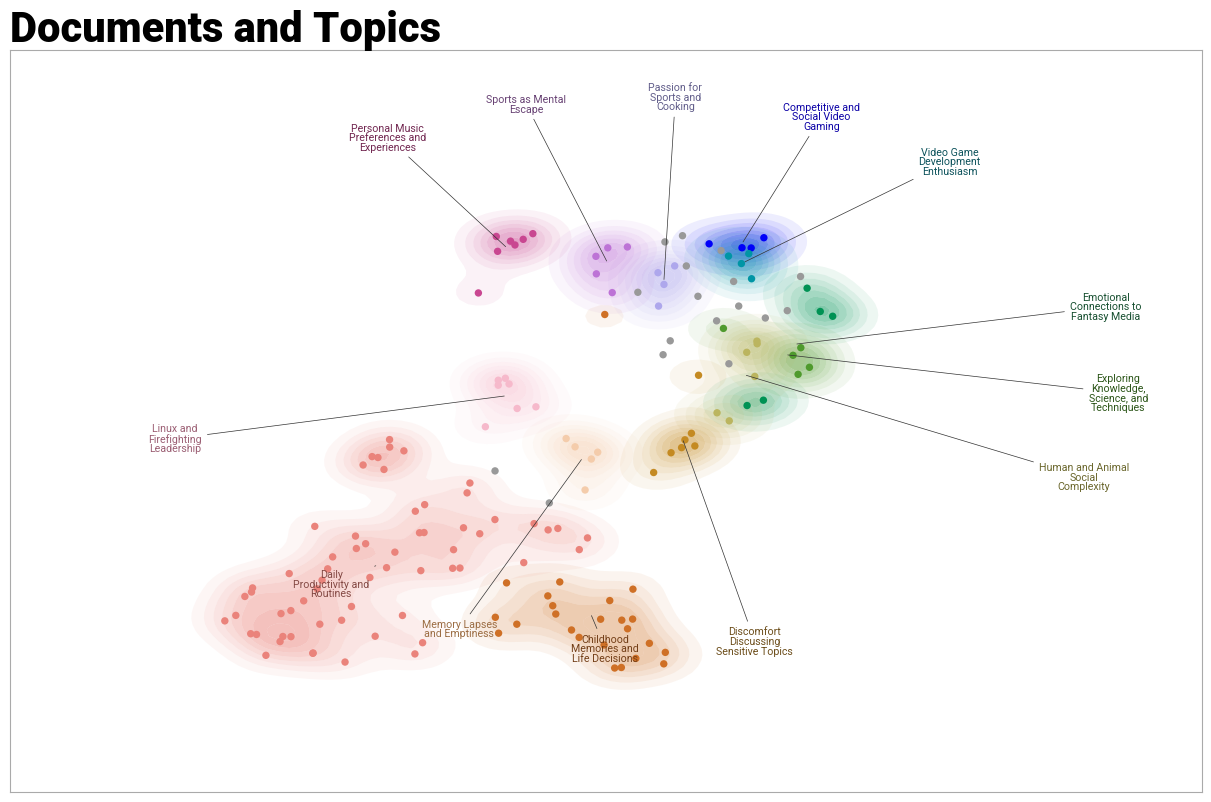

Translating topic words to English...

Translated Topics (Portuguese → English):
Topic 0: day, go, afternoon, to do, today
Topic 1: years, father, memory, before, soccer
Topic 2: to write, I feel comfortable, detail, comfortable, I feel
Topic 3: 14, cause, acceptance, , 
Topic 4: music, to hear, taste, I like, quite
Topic 5: constant, capacity, to use, other, any
Topic 6: to feel, thoughts, alone, I can, to play
Topic 7: history, anime, generally, part, special interest
Topic 8: to know, techniques, why, values, learning
Topic 9: nothing, to remember, genuinely, important, so
Topic 10: games, since, Since I was little, I grew, other people
Topic 11: game, self, day work, exists, online
Topic 12: sport, moments, soccer, power, any
DEBUG: Available topics for plotting: [0, 1, 2, 3, 4, 5]
DEBUG: Topic 0 -> Label: Daily Productivity and Routines
DEBUG: Topic 1 -> Label: Childhood Memories and Life Decisions
DEBUG: Topic 2 -> Label: Discomfort Discussing Sensitive Topics
DEBUG: Topic 3 -> L

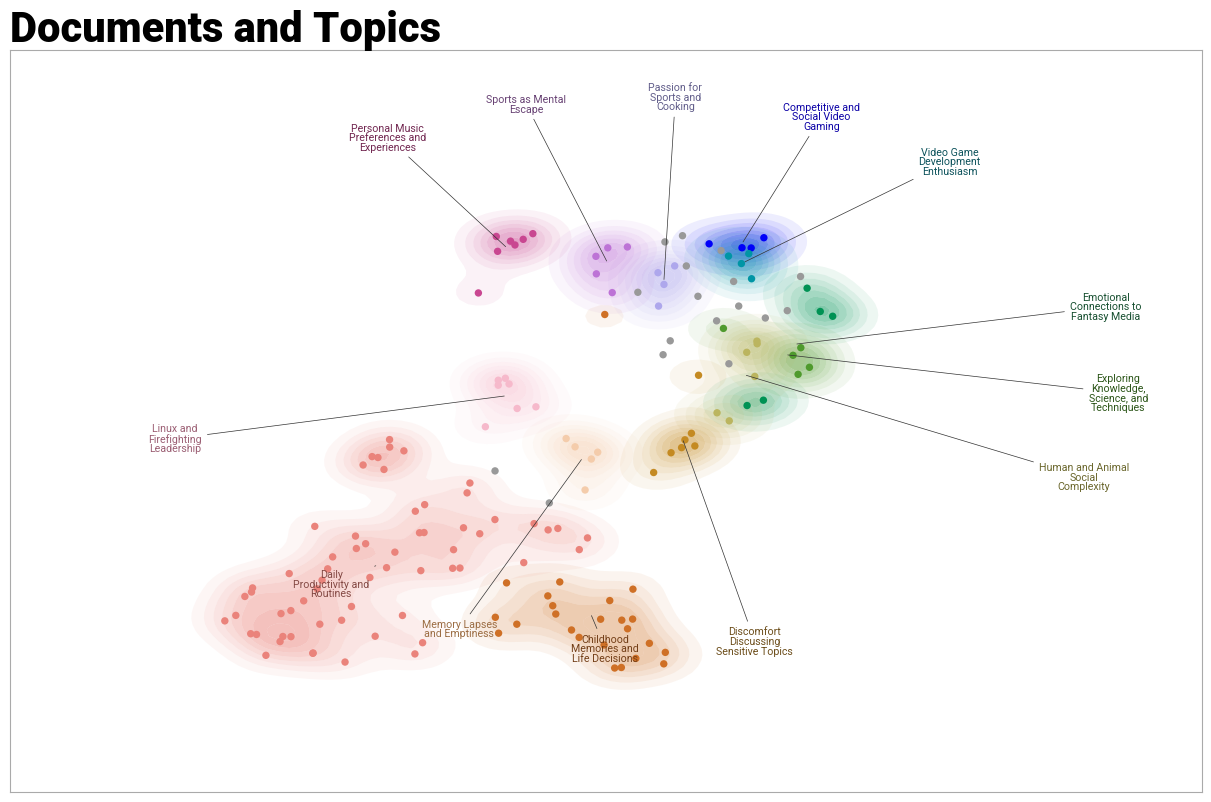

In [37]:
run_bertopic_viz(topic_model, df_group, output_folder, "Male")

# All

In [38]:
folder = next(f for f in folders if f.startswith("All_"))
print(folder)
df_group, topic_model, output_folder = preliminary_steps(folder)
check_hierarchy(topic_model, df_group, output_folder, "All")

All_20250818_152521_minsize6
Running preliminary steps for folder: All_20250818_152521_minsize6
All


100%|██████████| 17/17 [00:00<00:00, 598.51it/s]


🔧 Applying hierarchy specific optimizations...
🖼️  Saved bertopic_hierarchy_All as PNG: 20250826_234915_bertopic_hierarchy_all.png
📊 Saved bertopic_hierarchy_All as HTML: 20250826_234915_bertopic_hierarchy_all.html
✅ Total saved: 2 file(s) for 'bertopic_hierarchy_All'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_results/All_20250818_152521_minsize6
------------------------------------------------------------


🔧 Applying topics specific optimizations...
🖼️  Saved bertopic_topics_All as PNG: 20250826_234916_bertopic_topics_all.png
📊 Saved bertopic_topics_All as HTML: 20250826_234916_bertopic_topics_all.html
✅ Total saved: 2 file(s) for 'bertopic_topics_All'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_results/All_20250818_152521_minsize6
------------------------------------------------------------


.
├─gosto_animais_ler_interesse_forma
│    ├─■──politica_tentativa_políticas_historia_constante ── Topic: 14
│    └─gosto_animais_ler_interesse_adoro
│         ├─gosto_ler_forma_adoro_interesse
│         │    ├─gosto_ler_desporto_forma_livros
│         │    │    ├─ler_gosto_livros_forma_mundo
│         │    │    │    ├─■──ler_livros_forma_gosto_saga ── Topic: 9
│         │    │    │    └─■──conhecer_gosto_viajar_adoro_mundo ── Topic: 2
│         │    │    └─■──desporto_gosto_futebol_comunidade_ver ── Topic: 11
│         │    └─gosto_jogos_interesse_física_jogar
│         │         ├─■──jogos_gosto_jogar_jogo_pequeno ── Topic: 5
│         │         └─■──gosto_física_interesse_alimentação_tudo ── Topic: 12
│         └─■──animais_gatos_animal_têm_interesse ── Topic: 16
└─fazer_dia_porque_hoje_ainda
     ├─fazer_dia_porque_hoje_ainda
     │    ├─escrever_vezes_tudo_momento_espero
     │    │    ├─■──escrever_questionário_vezes_parece_nada ── Topic: 4
     │    │    └─■──momento_tudo_medo_o

In [39]:
topic_info = topic_model.get_topic_info()
display(topic_info)
topic_info.to_csv(f"{output_folder}/topic_info.csv", index=False)

Topic  Count                                      Name  \
0      -1    121                   -1_dia_pessoas_algo_mim   
1       0     43                   0_tarde_acordei_hoje_ir   
2       1     36              1_anos_altura_comigo_memória   
3       2     27             2_conhecer_gosto_viajar_adoro   
4       3     23               3_fazer_coisas_trabalho_dia   
5       4     23      4_escrever_questionário_vezes_parece   
6       5     22                  5_jogos_gosto_jogar_jogo   
7       6     20   6_phda_medicação_diagnóstico_psiquiatra   
8       7     20       7_música_ouvir_ouvir música_músicas   
9       8     15                 8_eventos_algum_dia_sinto   
10      9     14                  9_ler_livros_forma_gosto   
11     10     14                 10_momento_tudo_medo_onde   
12     11     14      11_desporto_gosto_futebol_comunidade   
13     12     12     12_gosto_física_interesse_alimentação   
14     13     11                 13_morte_anos_avô_emoções   
15     14      9  14_politica_tentativa_políticas_historia   
16     15      9                15_super_bom_nervoso_feliz   
17     16      8               16_animais_gatos_animal_têm   
18     17      6               17_avós_memória_ouro_lembro   

                                       CustomName  \
0                                   Outlier Topic   
1         Daily Routines and Personal Reflections   
2            Friendship Loss and Social Exclusion   
3       Experiencing Culture and Creative Hobbies   
4       Personal Productivity and Work Challenges   
5                   Mental Fatigue and Rumination   
6                      Video Games and Creativity   
7           Mental Health Diagnosis and Treatment   
8                  Personal Engagement with Music   
9        Personal Experiences and Self-Reflection   
10            Personal Reading and Book Obsession   
11           Uncertainty About Future in Portugal   
12             Passion for Sports and Competition   
13               Personal Interests and Wellbeing   
14              Impact of Loss on Personal Growth   
15              Art, Politics, and Social Justice   
16      Overcoming Challenges and Personal Growth   
17  Animal Welfare and Human-Animal Relationships   
18           Childhood Memories with Grandparents   

                                       Representation  \
0   [dia, pessoas, algo, mim, hoje, sempre, fazer,...   
1   [tarde, acordei, hoje, ir, dia, casa, trabalha...   
2   [anos, altura, comigo, memória, dizer, amigos,...   
3   [conhecer, gosto, viajar, adoro, mundo, porque...   
4   [fazer, coisas, trabalho, dia, tempo, senti, p...   
5   [escrever, questionário, vezes, parece, nada, ...   
6   [jogos, gosto, jogar, jogo, pequeno, área, des...   
7   [phda, medicação, diagnóstico, psiquiatra, dep...   
8   [música, ouvir, ouvir música, músicas, fazer, ...   
9   [eventos, algum, dia, sinto, memórias, aconteç...   
10  [ler, livros, forma, gosto, saga, comprar, his...   
11  [momento, tudo, medo, onde, futuro, vida, elei...   
12  [desporto, gosto, futebol, comunidade, ver, ba...   
13  [gosto, física, interesse, alimentação, tudo, ...   
14  [morte, anos, avô, emoções, controlo, doença, ...   
15  [politica, tentativa, políticas, historia, con...   
16  [super, bom, nervoso, feliz, apresentação, tes...   
17  [animais, gatos, animal, têm, interesse, los, ...   
18  [avós, memória, ouro, lembro, avó, avô, conhec...   

                                              KeyBERT  \
0   [altura, ir, fazer exame, memória, sentir, com...   
1   [hoje acordei, acordei, acordar, fiquei, comec...   
2   [ansiedade, altura, ia, comigo, medo, mim, ant...   
3   [viajar, gosto fazer, sentir, viver, paixão, s...   
4   [trabalhei, acordei, stress, hoje senti, taref...   
5   [stressar, dificuldades, escrever, adiar, inco...   
6   [gosto jogar, game dev, adoro conhecer, jogar ...   
7   [psiquiatra, pânico, depressão, psicóloga, doe...   
8   [ouvir música, música, músicas, tocar, ouvir

In [40]:
run_bertopic_evals(topic_model, df_group, output_folder)

Silhouette score calculated on 326 documents across 18 topics
Silhouette Score: 0.0377
Calculating topic coherence using UMass metric...
Vectorizer available!
Average Topic Coherence (UMass): -1.5527
Individual Topic Coherences:
  Topic 0: -1.3587
  Topic 1: -1.5070
  Topic 2: -1.7746
  Topic 3: -1.9216
  Topic 4: -2.0273
  Topic 5: -1.6944
  Topic 6: -0.9458
  Topic 7: -1.0725
  Topic 8: -1.9301
  Topic 9: -1.5970
  Topic 10: -2.0026
  Topic 11: -1.6963
  Topic 12: -1.8650
  Topic 13: -1.6157
  Topic 14: -0.9821
  Topic 15: -1.6182
  Topic 16: -0.9514
  Topic 17: -1.3874
Coherence results saved to ../../outputs/bertopic_results/All_20250818_152521_minsize6/


Number of texts: 447
Number of topics: 447


Document  Topic  \
0    Adoro cozinhar, porque sinto que é a forma ide...     -1   
1    Gosto de ver séries porque relatam relações sa...      2   
2    Campos de ferias. Temos que criar o campo todo...     -1   
3    Taylor Swift, amo o seu liricismo e a maneira ...     14   
4    Historia da arte \nÉ só tão interessante. Para...     14   
..                                                 ...    ...   
442  O ponto em que sociedade se está a tornar,: eg...     -1   
443  Gostava que não dissessem : toda a gente tem p...      6   
444  Não sei explicar o que se anda a passar comigo...     -1   
445  De momento, na minha cabeça, só rumino sobre o...     -1   
446  Alguém me mande um milagre, I am going crazy, ...      0   

                                         Name  \
0                     -1_dia_pessoas_algo_mim   
1               2_conhecer_gosto_viajar_adoro   
2                     -1_dia_pessoas_algo_mim   
3    14_politica_tentativa_políticas_historia   
4    14_politica_tentativa_políticas_historia   
..                                        ...   
442                   -1_dia_pessoas_algo_mim   
443   6_phda_medicação_diagnóstico_psiquiatra   
444                   -1_dia_pessoas_algo_mim   
445                   -1_dia_pessoas_algo_mim   
446                   0_tarde_acordei_hoje_ir   

                                    CustomName  \
0                                Outlier Topic   
1    Experiencing Culture and Creative Hobbies   
2                                Outlier Topic   
3            Art, Politics, and Social Justice   
4            Art, Politics, and Social Justice   
..                                         ...   
442                              Outlier Topic   
443      Mental Health Diagnosis and Treatment   
444                              Outlier Topic   
445                              Outlier Topic   
446    Daily Routines and Personal Reflections   

                                        Representation  \
0    [dia, pessoas, algo, mim, hoje, sempre, fazer,...   
1    [conhecer, gosto, viajar, adoro, mundo, porque...   
2    [dia, pessoas, algo, mim, hoje, sempre, fazer,...   
3    [politica, tentativa, políticas, historia, con...   
4    [politica, tentativa, políticas, historia, con...   
..                                                 ...   
442  [dia, pessoas, algo, mim, hoje, sempre, fazer,...   
443  [phda, medicação, diagnóstico, psiquiatra, dep...   
444  [dia, pessoas, algo, mim, hoje, sempre, fazer,...   
445  [dia, pessoas, algo, mim, hoje, sempre, fazer,...   
446  [tarde, acordei, hoje, ir, dia, casa, trabalha...   

                                               KeyBERT  \
0    [altura, ir, fazer exame, memória, sentir, com...   
1    [viajar, gosto fazer, sentir, viver, paixão, s...   
2    [altura, ir, fazer exame, memória, sentir, com...   
3    [entender, politica, políticas, política, expr...   
4    [entender, politica, políticas, política, expr...   
..                                                 ...   
442  [altura, ir, fazer exame, memória, sentir, com...   
443  [psiquiatra, pânico, depressão, psicóloga, doe...   
444  [altura, ir, fazer exame, memória, sentir, com...   
445  [altura, ir, fazer exame, memória, sentir, com...   
446  [hoje acordei, acordei, acordar, fiquei, comec...   

                                          OpenAI  \
0           [Personal Challenges and Resilience]   
1    [Experiencing Culture and Creative Hobbies]   
2           [Personal Challenges and Resilience]   
3            [Art, Politics, and Social Justice]   
4            [Art, Politics, and Social Justice]   
..                                           ...   
442         [Personal Challenges and Resilience]   
443      [Mental Health Diagnosis and Treatment]   
444         [Personal Challenges and Resilience]   
445         [Personal Challenges and Resilience]   
446    [Daily Routines and Personal Reflections]   

                                                   MMR  

🔧 Applying heatmap specific optimizations...
🖼️  Saved bertopic_heatmap_All as PNG: 20250826_234918_bertopic_heatmap_all.png
📊 Saved bertopic_heatmap_All as HTML: 20250826_234918_bertopic_heatmap_all.html
✅ Total saved: 2 file(s) for 'bertopic_heatmap_All'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_results/All_20250818_152521_minsize6
------------------------------------------------------------


4it [00:00, 97.96it/s]

🔧 Applying topics_per_class specific optimizations...


🖼️  Saved bertopic_topics_per_class_All as PNG: 20250826_234920_bertopic_topics_per_class_all.png
📊 Saved bertopic_topics_per_class_All as HTML: 20250826_234920_bertopic_topics_per_class_all.html
✅ Total saved: 2 file(s) for 'bertopic_topics_per_class_All'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_results/All_20250818_152521_minsize6
------------------------------------------------------------


🖼️  Saved bertopic_document_datamap_All as PNG: 20250826_234924_bertopic_document_datamap_all.png
📊 Saved bertopic_document_datamap_All as HTML: 20250826_234924_bertopic_document_datamap_all.html
✅ Total saved: 2 file(s) for 'bertopic_document_datamap_All'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_results/All_20250818_152521_minsize6
------------------------------------------------------------


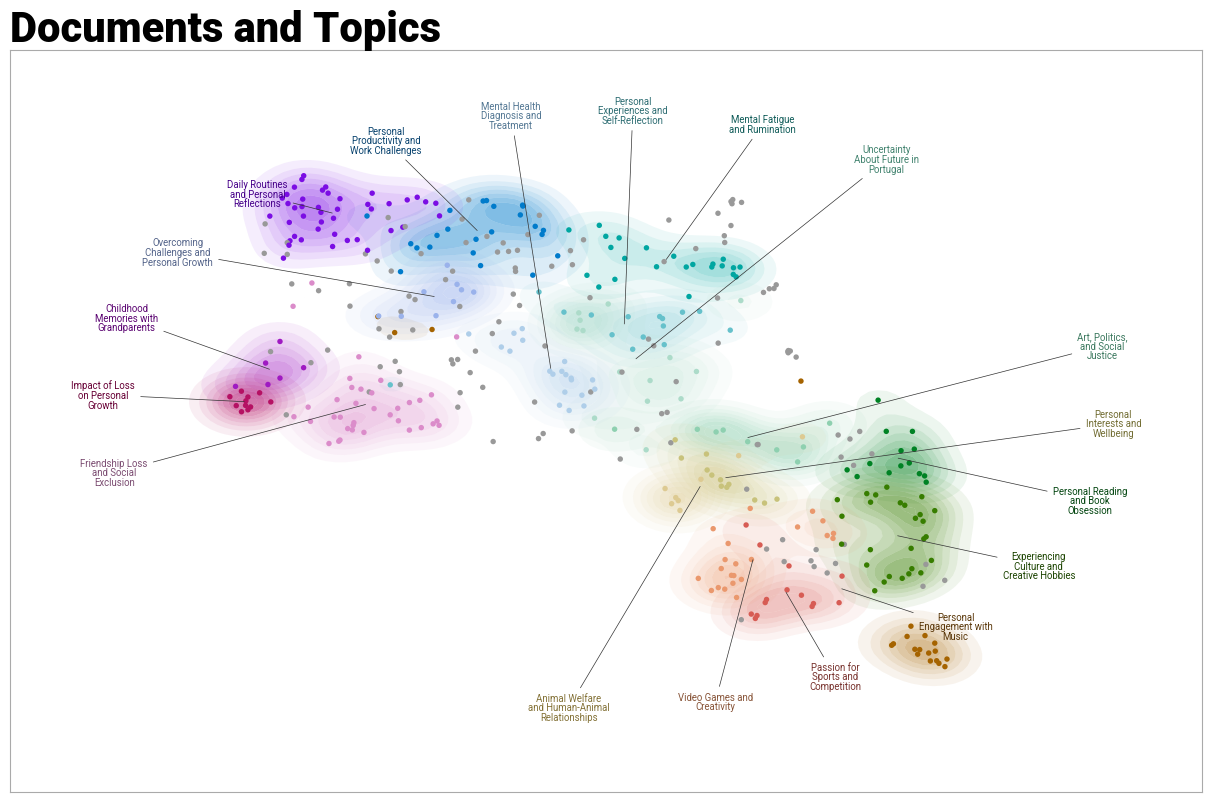

Translating topic words to English...

Translated Topics (Portuguese → English):
Topic 0: afternoon, I woke up, today, go, day
Topic 1: years, height, with me, memory, to say
Topic 2: to know, I like, travel, I adore, world
Topic 3: to do, things, work, day, time
Topic 4: to write, questionnaire, times, like, nothing
Topic 5: games, I like, to play, game, small
Topic 6: adhd, medication, diagnosis, psychiatrist, depression
Topic 7: music, to hear, listen, songs, to do
Topic 8: events, some, day, I feel, memories
Topic 9: to read, books, shape, I like, saga
Topic 10: moment, all, fear, where, future
Topic 11: sport, I like, soccer, community, see
Topic 12: I like, physical, interest, food, all
Topic 13: death, years, grandmother, emotions, control
Topic 14: policy, attempt, policies, history, constant
Topic 15: super, good, nervous, happy, presentation
Topic 16: animals, cats, animal, he has, interest
Topic 17: grandparents, memory, gold, I remember, grandmother
DEBUG: Available topics 

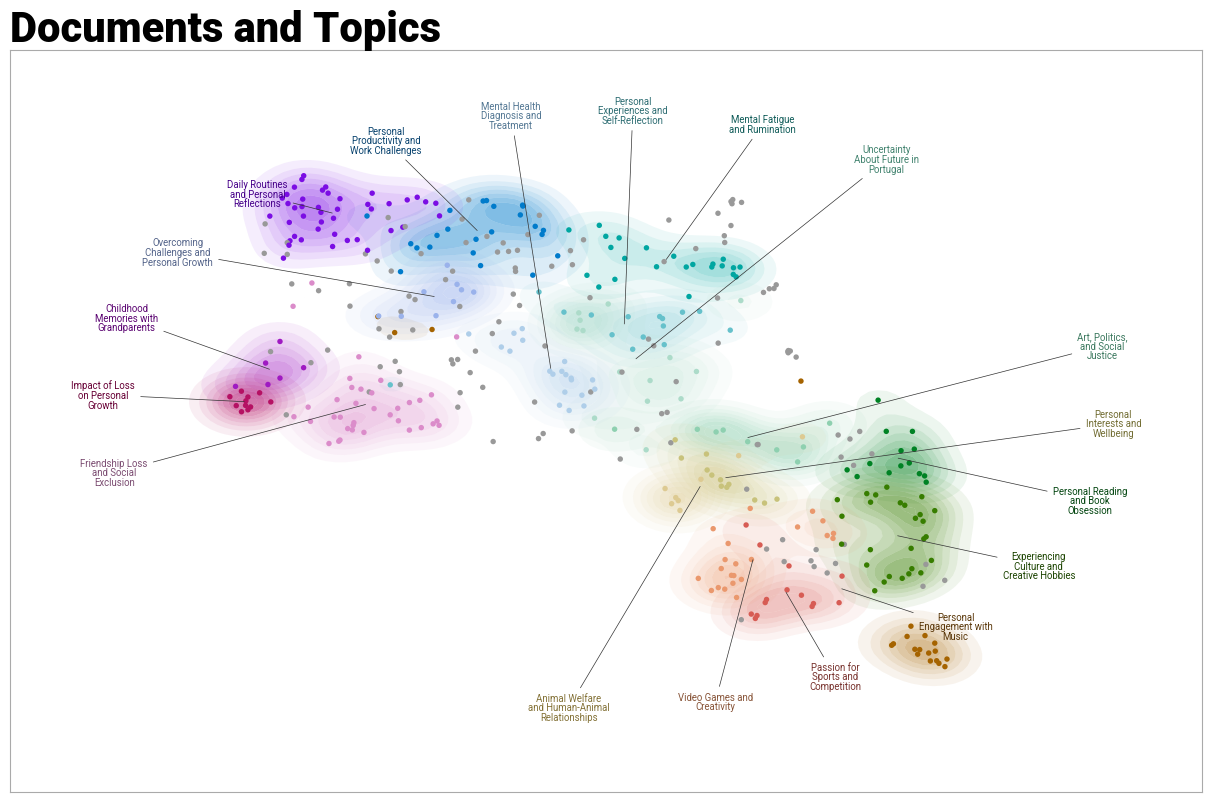

In [41]:
run_bertopic_viz(topic_model, df_group, output_folder, "All")